In [30]:
import numpy as np
import sys,os
import matplotlib.pyplot as plt
from scipy.stats import multivariate_t, multivariate_normal
import sklearn
from sklearn.covariance import GraphicalLasso
import scipy
from sklearn.metrics import zero_one_loss
from sklearn.metrics.pairwise import pairwise_kernels
import time
import tqdm
import networkx as nx
import pandas as pd

sys.path.insert(0, 'C:/Users/User/Code/DyGraph')

import DyGraph as dg
import pickle
from sklearn.datasets import make_sparse_spd_matrix
from utils import calc_one_zero_error, calc_f1, calc_precision, calc_recall, calc_density, calc_roc_auc, calc_balanced_accuaray
import port_measures as pm

# Create Raw data

In [ ]:
# import requests
# import yfinance as yf
# import pickle
# ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
# groups_according_to_ticker = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
# start_date= "2016-01-01"
# end_date="2023-02-01"

# data = yf.download(ticker_list, start_date , end_date)
# log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
# log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
# price = data['Adj Close'].iloc[1:]
# groups = np.array([j for _,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

# gogn = {'data':data, 'ticker_list':ticker_list, 'groups_according_to_ticker':groups_according_to_ticker, 'log_returns':log_returns,
#         'log_returns_scaled':log_returns_scaled, 'price':price, 'groups':groups}

            
# with open(f'../data/case_study_etf/raw_etf.pkl', 'wb') as handle:
#         pickle.dump(gogn, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Load

In [141]:
with open(f'../data/case_study_etf/gaussian_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
    gaussian_port = pickle.load(handle)

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_100.pkl', 'rb') as handle:
    t_port = pickle.load(handle)


with open(f'../data/case_study_etf/t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

# with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_ind_60_diff_kappa.pkl', 'rb') as handle:
#     t_port_diff_kappa = pickle.load(handle)

# with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_ind_60_diff_kappa2.pkl', 'rb') as handle:
#     t_port_diff_kappa2 = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_kappa_0.9_nr_quad_10_etf2.pkl', 'rb') as handle:
    gt_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)




with open(f'../data/case_study_etf/covariance_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
    cov_port = pickle.load(handle)

with open(f'../data/case_study_etf/LedoitWolf_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
    LedoitWolf_port = pickle.load(handle)


In [2]:
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)


In [88]:
len(t_port['ticker_list']) == len(gaussian_port['ticker_list'])

True

static compare alpha

In [ ]:
def log_lik(mean,cov, X, liktype, nu = None):

    if liktype == "gaussian":
        lik = np.sum(multivariate_normal.logpdf(X, mean=mean, cov=cov, allow_singular=True))
    elif liktype == "t":
        lik = np.sum(multivariate_t.logpdf(X,loc = mean, shape=cov, df = nu))
    else:
        assert False, "likelihood not correct"

    return lik

def extract_info(in_dict,lik_type,w_fix):


    alphas = in_dict['alphas']
    price = in_dict['price']
    X = in_dict['X']

    sharpes_s = {i: [] for i in range(len(alphas))}
    sharpes_m = {i: [] for i in range(len(alphas))}
    ebics = {i: [] for i in range(len(alphas))}
    mdds_s = {i: [] for i in range(len(alphas))}
    mdds_m = {i: [] for i in range(len(alphas))}
    thetas= {i: [] for i in range(len(alphas))}
    Ss= {i: [] for i in range(len(alphas))}
    Cs= {i: [] for i in range(len(alphas))}
    gammas = {i: [] for i in range(len(alphas))}
    nus = {i: [] for i in range(len(alphas))}
    fro_norms = {i: [] for i in range(len(alphas))}
    ws_s = {i: [] for i in range(len(alphas))}
    ws_m = {i: [] for i in range(len(alphas))}
    mus = {i: [] for i in range(len(alphas))}
    mus_s = {i: [] for i in range(len(alphas))}
    mus_m = {i: [] for i in range(len(alphas))}
    vars_s = {i: [] for i in range(len(alphas))}
    vars_m = {i: [] for i in range(len(alphas))}
    rs_s = {i: [] for i in range(len(alphas))}
    rs_m = {i: [] for i in range(len(alphas))}
    omegas_s = {i: [] for i in range(len(alphas))}
    omegas_m = {i: [] for i in range(len(alphas))}
    port_price_s = {i: [] for i in range(len(alphas))}
    port_price_m = {i: [] for i in range(len(alphas))}
    sigmas_s = {i: [] for i in range(len(alphas))}
    sigmas_m = {i: [] for i in range(len(alphas))}
    time_forecast = {i: [] for i in range(len(alphas))}
    likelihoods = {i: [] for i in range(len(alphas))}

    for alpha_cnt, alpha in enumerate(alphas):

        for time_cnt, i in enumerate(in_dict['time_index']): 

            # get precision/covariance
            theta = in_dict['thetas'][alpha_cnt][time_cnt][-1].copy()
            precision_matrix = in_dict['thetas'][alpha_cnt][time_cnt][-1]
            precision_matrix[np.abs(precision_matrix)<1e-5]= 0.0
            S = np.linalg.inv(precision_matrix)
            nu = in_dict['nus'][alpha_cnt][time_cnt]
            if lik_type == 't':
                C = (nu/(nu-2))
                S = C*S
            else:
                nu = None
                C = 1

            # Update precision matrix 
            precision_matrix = np.linalg.inv(S) 

            mu = in_dict['mus'][alpha_cnt][time_cnt]

            # portfolio weights sharpe
            w_s, mu_s, var_s = pm.portfolio_opt(S,precision_matrix, mu, X[i-500:i], type = 'sharpe',w_fix = w_fix)
            portfolio_s = np.dot(np.array(price.iloc[i+1:i + 20]),w_s)
            port_price_s[alpha_cnt].append(portfolio_s)
            log_returns_s = np.array(100*np.log(1+pd.DataFrame(portfolio_s).pct_change()).dropna())
            r_s = (portfolio_s[-1]-portfolio_s[0])/portfolio_s[0]
            sigma_s = np.std(log_returns_s)
            sharpe_s = pm.sharpe(r_s,sigma_s)
            sharpes_s[alpha_cnt].append(sharpe_s)
            mdds_s[alpha_cnt].append(pm.max_drawdown(portfolio_s))
            omegas_s[alpha_cnt].append(pm.omega(np.squeeze(log_returns_s)))
            ws_s[alpha_cnt].append(w_s)
            mus_s[alpha_cnt].append(mu_s)
            vars_s[alpha_cnt].append(var_s)
            rs_s[alpha_cnt].append(r_s)
            sigmas_s[alpha_cnt].append(sigma_s)

            # portfolio weights minimum variance
            w_m, mu_m, var_m = pm.portfolio_opt(S,precision_matrix, mu, X[i-500:i], type = 'gmv',w_fix = w_fix)

            portfolio_m = np.dot(price.iloc[i+1:i + 20],w_m)
            port_price_m[alpha_cnt].append(portfolio_m)
            log_returns_m = np.array(100*np.log(1+pd.DataFrame(portfolio_m).pct_change()).dropna())
            r_m = (portfolio_m[-1]-portfolio_m[0])/portfolio_m[0]
            sigma_m = np.std(log_returns_m)
            sharpe_m = pm.sharpe(r_m,sigma_m)
            sharpes_m[alpha_cnt].append(sharpe_m)
            mdds_m[alpha_cnt].append(pm.max_drawdown(portfolio_m))
            omegas_m[alpha_cnt].append(pm.omega(np.squeeze(log_returns_m)))
            ws_m[alpha_cnt].append(w_m)
            mus_m[alpha_cnt].append(mu_m)
            vars_m[alpha_cnt].append(var_m)
            rs_m[alpha_cnt].append(r_m)
            sigmas_m[alpha_cnt].append(sigma_m)
            likelihoods[alpha_cnt].append(log_lik(np.zeros(theta.shape[1]) ,np.linalg.inv(theta), X[i-500:i]-mu, liktype = lik_type, nu = nu))

            

            # add stuff independent of portfolio
            time_forecast[alpha_cnt].append(price.index[i+1:i + 20])
            # ebics[alpha_cnt].append(ebic(np.zeros(S.shape[0]),S, precision_matrix, log_returns_scaled, liktype=lik_type, nu = dg_opt.nu, beta = 0.5))

            # Guess next theta
            # if lik_type in ('groupt-t', 'skew-group-t', 't', 'gaussian'):
            #     theta_init = dg_opt.theta.copy()


    out_dict = {'time_forecast':time_forecast,'likelihoods':likelihoods,
                'sharpes_s':sharpes_s,  'mdds_s':mdds_s,   'ws_s':ws_s, 'mus_s':mus_s, 'vars_s':vars_s, 'rs_s':rs_s, 
                'omegas_s':omegas_s,'port_price_s':port_price_s, 'sigmas_s':sigmas_s,
                'sharpes_m':sharpes_m,  'mdds_m':mdds_m,   'ws_m':ws_m, 'mus_m':mus_m, 'vars_m':vars_m, 'rs_m':rs_m, 
                'omegas_m':omegas_m,'port_price_m':port_price_m, 'sigmas_m':sigmas_m}
    
    return out_dict

def extract_info_dynamic(in_dict,lik_type,w_fix):


    alphas = in_dict['alphas']
    time_index = in_dict['time_index']
    price = in_dict['price']
    X = in_dict['X']

    sharpes_s = {i: [] for i in range(len(alphas))}
    sharpes_m = {i: [] for i in range(len(alphas))}
    ebics = {i: [] for i in range(len(alphas))}
    mdds_s = {i: [] for i in range(len(alphas))}
    mdds_m = {i: [] for i in range(len(alphas))}
    thetas= {i: [] for i in range(len(alphas))}
    Ss= {i: [] for i in range(len(alphas))}
    Cs= {i: [] for i in range(len(alphas))}
    gammas = {i: [] for i in range(len(alphas))}
    nus = {i: [] for i in range(len(alphas))}
    fro_norms = {i: [] for i in range(len(alphas))}
    ws_s = {i: [] for i in range(len(alphas))}
    ws_m = {i: [] for i in range(len(alphas))}
    mus = {i: [] for i in range(len(alphas))}
    mus_s = {i: [] for i in range(len(alphas))}
    mus_m = {i: [] for i in range(len(alphas))}
    vars_s = {i: [] for i in range(len(alphas))}
    vars_m = {i: [] for i in range(len(alphas))}
    rs_s = {i: [] for i in range(len(alphas))}
    rs_m = {i: [] for i in range(len(alphas))}
    omegas_s = {i: [] for i in range(len(alphas))}
    omegas_m = {i: [] for i in range(len(alphas))}
    port_price_s = {i: [] for i in range(len(alphas))}
    port_price_m = {i: [] for i in range(len(alphas))}
    sigmas_s = {i: [] for i in range(len(alphas))}
    sigmas_m = {i: [] for i in range(len(alphas))}
    time_forecast = {i: [] for i in range(len(alphas))}
    likelihoods = {i: [] for i in range(len(alphas))}

    pbar = tqdm.tqdm(total = len(time_index)*len(alphas), position=1)

    for alpha_cnt, alpha in enumerate(alphas):

        for time_cnt, i in enumerate(in_dict['time_index']): 
            pbar.set_description(f"i {i}, alpha {alpha}")

            # get precision/covariance
            thetas = in_dict['thetas'][alpha_cnt][time_cnt].copy()
            theta = in_dict['thetas'][alpha_cnt][time_cnt][-1].copy()
            precision_matrix = in_dict['thetas'][alpha_cnt][time_cnt][-1]
            precision_matrix[np.abs(precision_matrix)<1e-5]= 0.0
            S = np.linalg.inv(precision_matrix)
            nu = in_dict['nus'][alpha_cnt][time_cnt]
            if lik_type == 't':
                C = (nu/(nu-2))
                S = C*S
            else:
                nu = None
                C = 1

            # Update precision matrix 
            precision_matrix = np.linalg.inv(S) 

            mu = in_dict['mus'][alpha_cnt][time_cnt]

            # portfolio weights sharpe
            w_s, mu_s, var_s = pm.portfolio_opt(S,precision_matrix, mu, X[i-500:i], type = 'sharpe',w_fix = w_fix)
            portfolio_s = np.dot(np.array(price.iloc[i+1:i + 20]),w_s)
            port_price_s[alpha_cnt].append(portfolio_s)
            log_returns_s = np.array(100*np.log(1+pd.DataFrame(portfolio_s).pct_change()).dropna())
            r_s = (portfolio_s[-1]-portfolio_s[0])/portfolio_s[0]
            sigma_s = np.std(log_returns_s)
            sharpe_s = pm.sharpe(r_s,sigma_s)
            sharpes_s[alpha_cnt].append(sharpe_s)
            mdds_s[alpha_cnt].append(pm.max_drawdown(portfolio_s))
            omegas_s[alpha_cnt].append(pm.omega(np.squeeze(log_returns_s)))
            ws_s[alpha_cnt].append(w_s)
            mus_s[alpha_cnt].append(mu_s)
            vars_s[alpha_cnt].append(var_s)
            rs_s[alpha_cnt].append(r_s)
            sigmas_s[alpha_cnt].append(sigma_s)

            # portfolio weights minimum variance
            w_m, mu_m, var_m = pm.portfolio_opt(S,precision_matrix, mu, X[i-500:i], type = 'gmv',w_fix = w_fix)

            portfolio_m = np.dot(price.iloc[i+1:i + 20],w_m)
            port_price_m[alpha_cnt].append(portfolio_m)
            log_returns_m = np.array(100*np.log(1+pd.DataFrame(portfolio_m).pct_change()).dropna())
            r_m = (portfolio_m[-1]-portfolio_m[0])/portfolio_m[0]
            sigma_m = np.std(log_returns_m)
            sharpe_m = pm.sharpe(r_m,sigma_m)
            sharpes_m[alpha_cnt].append(sharpe_m)
            mdds_m[alpha_cnt].append(pm.max_drawdown(portfolio_m))
            omegas_m[alpha_cnt].append(pm.omega(np.squeeze(log_returns_m)))
            ws_m[alpha_cnt].append(w_m)
            mus_m[alpha_cnt].append(mu_m)
            vars_m[alpha_cnt].append(var_m)
            rs_m[alpha_cnt].append(r_m)
            sigmas_m[alpha_cnt].append(sigma_m)
            
            lik_tmp = 0
            w = d_t_port['obs_per_graph']
            for j in range(len(d_t_port['thetas'][0][0])):
                    X_tmp = X[j*w:(j+1)*w]
                    lik_tmp += log_lik(np.zeros(dg_opt.theta[j].shape[1]) ,np.linalg.inv(dg_opt.theta[j]), X_tmp-mu, liktype = lik_type, nu = dg_opt.nu[j])

            likelihoods[alpha_cnt].append(lik_tmp)

            

            # add stuff independent of portfolio
            time_forecast[alpha_cnt].append(price.index[i+1:i + 20])
            # ebics[alpha_cnt].append(ebic(np.zeros(S.shape[0]),S, precision_matrix, log_returns_scaled, liktype=lik_type, nu = dg_opt.nu, beta = 0.5))

            # Guess next theta
            # if lik_type in ('groupt-t', 'skew-group-t', 't', 'gaussian'):
            #     theta_init = dg_opt.theta.copy()

            pbar.update()

    pbar.close()
    out_dict = {'time_forecast':time_forecast,'likelihoods':likelihoods,
                'sharpes_s':sharpes_s,  'mdds_s':mdds_s,   'ws_s':ws_s, 'mus_s':mus_s, 'vars_s':vars_s, 'rs_s':rs_s, 
                'omegas_s':omegas_s,'port_price_s':port_price_s, 'sigmas_s':sigmas_s,
                'sharpes_m':sharpes_m,  'mdds_m':mdds_m,   'ws_m':ws_m, 'mus_m':mus_m, 'vars_m':vars_m, 'rs_m':rs_m, 
                'omegas_m':omegas_m,'port_price_m':port_price_m, 'sigmas_m':sigmas_m}
    
    return out_dict

In [35]:




with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
    static_gaussian_port_info = extract_info(static_gaussian_port,'gaussian', False)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)
    static_t_port_info = extract_info(static_t_port,'t', False)





In [74]:
with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.3_disjoint_50_element-wise.pkl', 'rb') as handle:
    d_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.3_disjoint_50_element-wise.pkl', 'rb') as handle:
    d_t_port = pickle.load(handle)



50

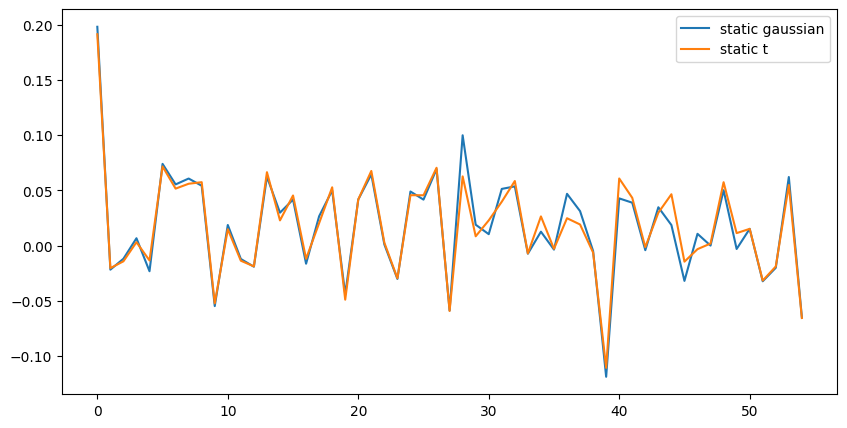

In [60]:
a = 1
var = 'sharpes_m'
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port_info[var][a], label = 'static gaussian')
ax.plot(static_t_port_info[var][a], label = 'static t')
ax.legend()

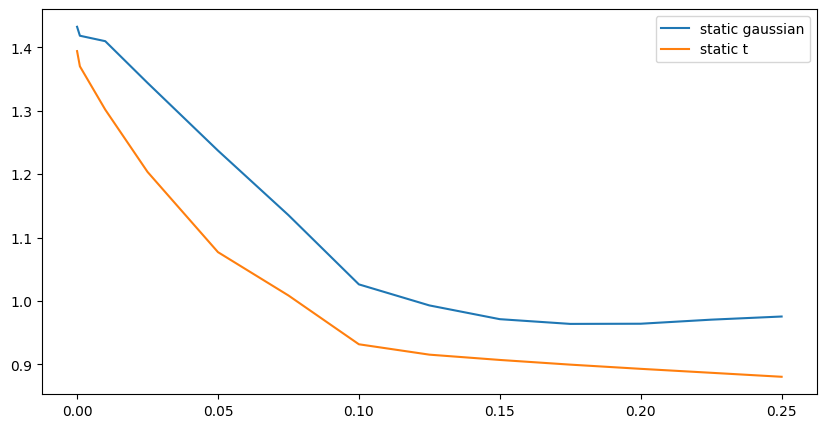

In [71]:

var = 'sigmas_s'


mean_mdd_t = []
mean_mdd_n = []
for cnt, alpha in enumerate(static_gaussian_port['alphas']):
    mean_mdd_n.append(np.median(static_gaussian_port_info[var][cnt]))
    mean_mdd_t.append(np.median(static_t_port_info[var][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.legend()


### Plot degrees of freedom

NameError: name 't_port' is not defined

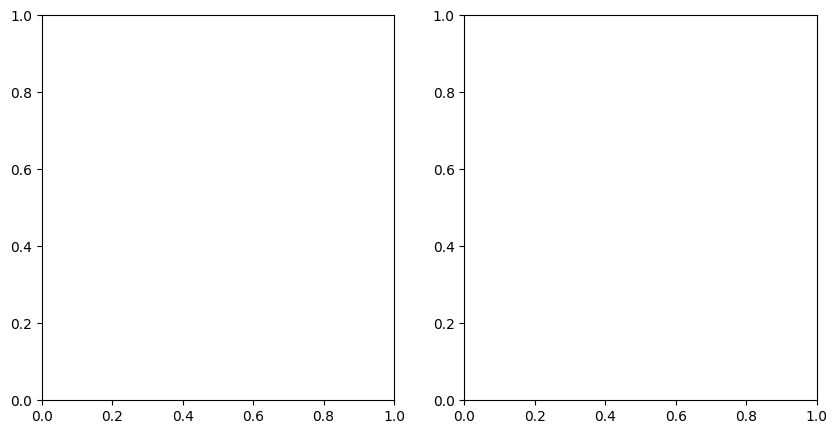

In [2]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].plot(t_port['time_change'],t_port['nus'][0])


ax[1].plot(t_port['time_change'][:len(gt_port['nus'][0])],np.array(gt_port['nus'][0])[:,0])
ax[1].plot(t_port['time_change'][:len(gt_port['nus'][0])],np.array(gt_port['nus'][0])[:,1])
ax[1].plot(t_port['time_change'][:len(gt_port['nus'][0])],np.array(gt_port['nus'][0])[:,6])
fig.autofmt_xdate()


### plot MDD

Compare Static

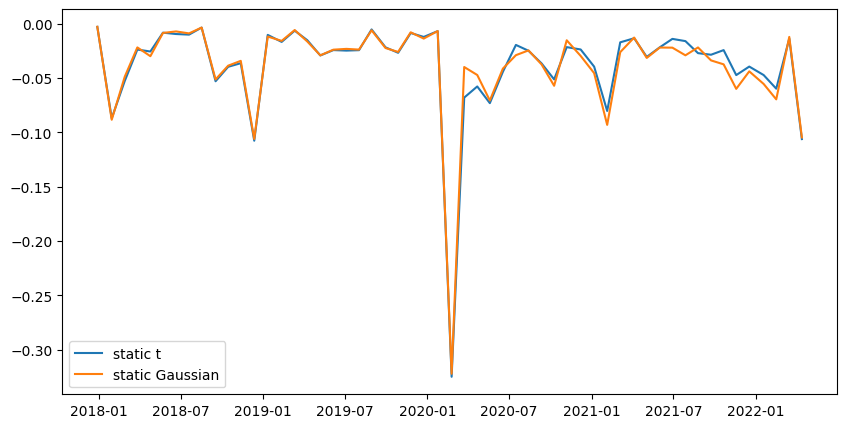

In [7]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)


k = 1

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_t_port['time_change'], static_t_port['mdds_m'][k], label = 'static t')
ax.plot(static_gaussian_port['time_change'], static_gaussian_port['mdds_m'][k], label = 'static Gaussian')
# ax.plot(static_gt_port['time_change'][:len(static_gt_port['mdds_s'][0])], static_gt_port['mdds_s'][0], label = 'static Gaussian')
#ax.plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price)], s_gt_price, label = 'static gt')
ax.legend()

Compare alpha

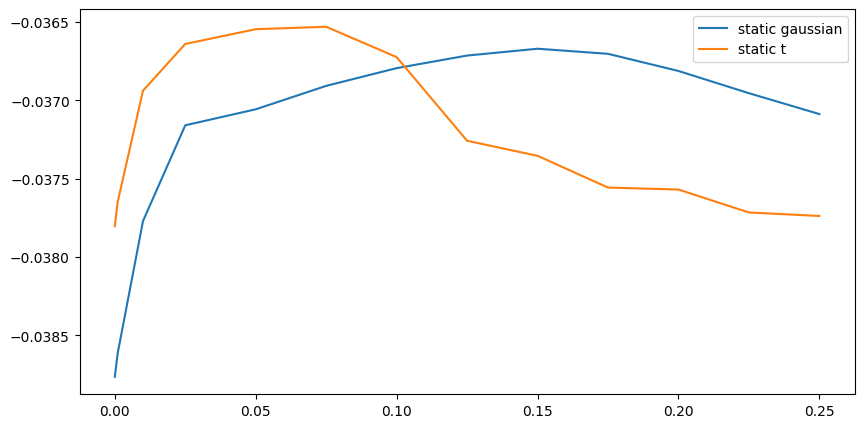

In [8]:



with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['mdds_m'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['mdds_m'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.legend()


Compare Dynamic

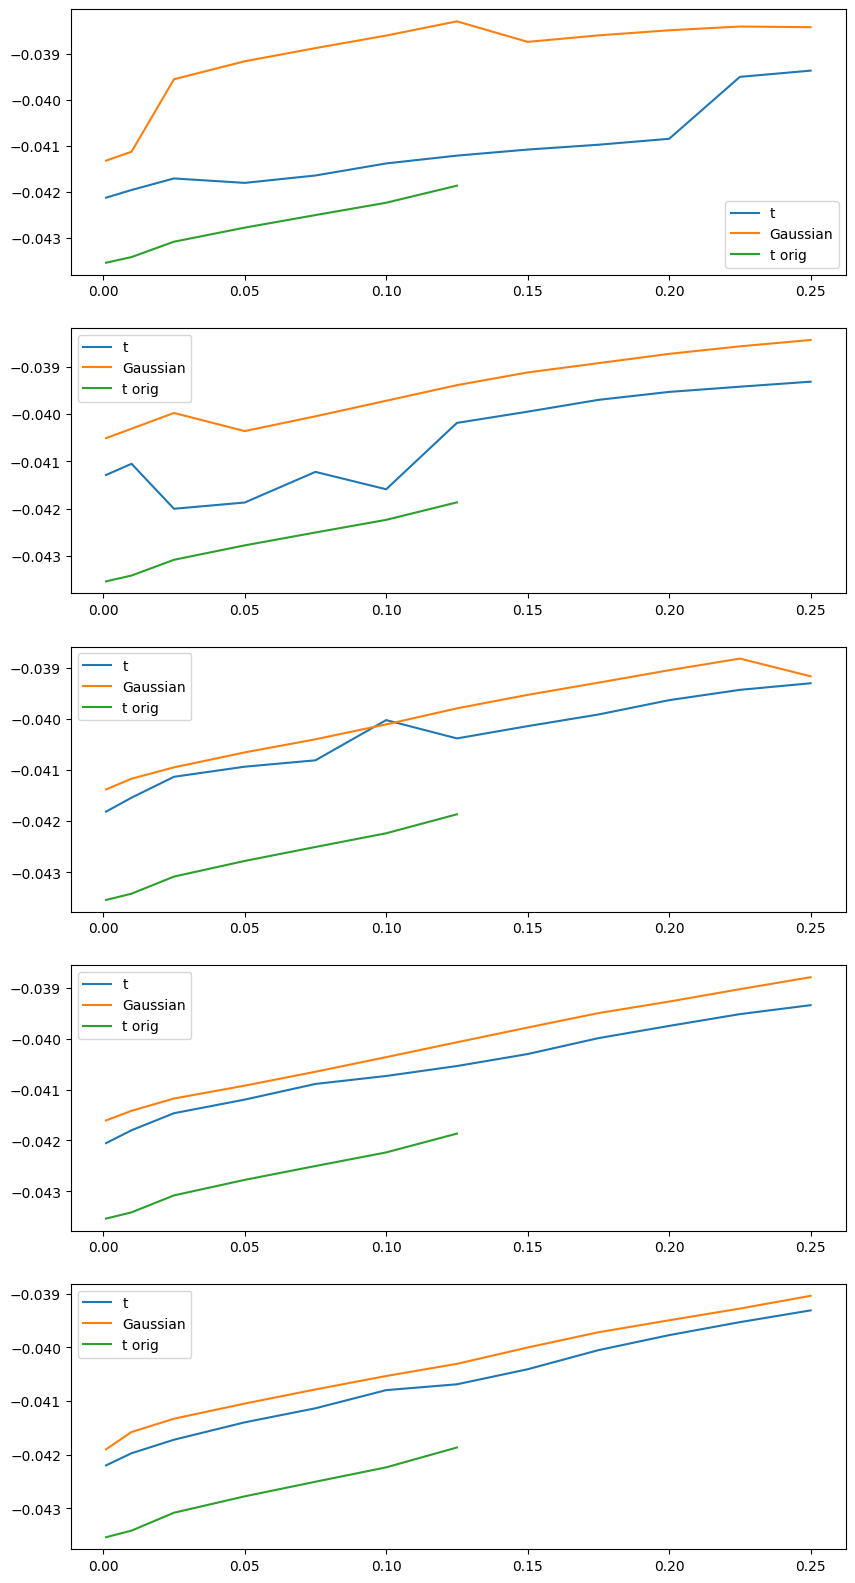

In [43]:
t_port = []
t_orig_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['mdds_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['mdds_s'][cnt]))
    
    n_port.append(mean_mdd_n)

    with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        t_portorig = pickle.load(handle)
    mean_mdd_t_orig = []
    for cnt, alpha in enumerate(t_portorig['alphas']):
        mean_mdd_t_orig.append(np.mean(t_portorig['mdds_s'][cnt]))
    t_orig_port.append(mean_mdd_t_orig)




fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')
    ax[cnt].plot(t_portorig['alphas'][:len(t_orig_port[cnt])], t_orig_port[cnt], label = f't orig')

    ax[cnt].legend()


Compare temporal 

c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\anaconda3\envs\DyGraph\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


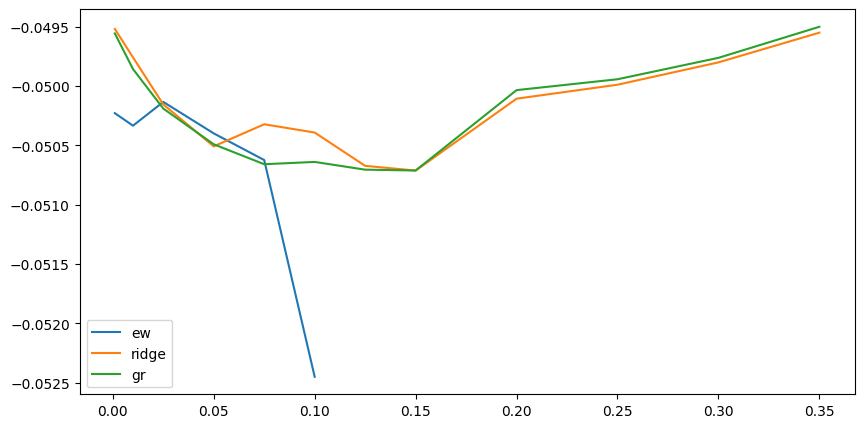

In [46]:


with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.1_disjoint_20.pkl', 'rb') as handle:
    t_port_ew = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.1_disjoint_20_ridge.pkl', 'rb') as handle:
    t_port_ridge = pickle.load(handle)


with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.1_disjoint_20_global-reconstruction.pkl', 'rb') as handle:
    t_port_gr = pickle.load(handle)

mean_mdd_ew = []
for cnt, alpha in enumerate(t_port_ew['alphas']):
    mean_mdd_ew.append(np.mean(t_port_ew['mdds_s'][cnt]))
mean_mdd_ridge = []
for cnt, alpha in enumerate(t_port_ridge['alphas']):
    mean_mdd_ridge.append(np.mean(t_port_ridge['mdds_s'][cnt]))
mean_mdd_gr = []
for cnt, alpha in enumerate(t_port_gr['alphas']):
    mean_mdd_gr.append(np.mean(t_port_gr['mdds_s'][cnt]))


fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.plot(t_port_ew['alphas'], mean_mdd_ew, label = f'ew')
ax.plot(t_port_ridge['alphas'], mean_mdd_ridge, label = f'ridge')
ax.plot(t_port_gr['alphas'], mean_mdd_gr, label = f'gr')


ax.legend()

### Plot weights

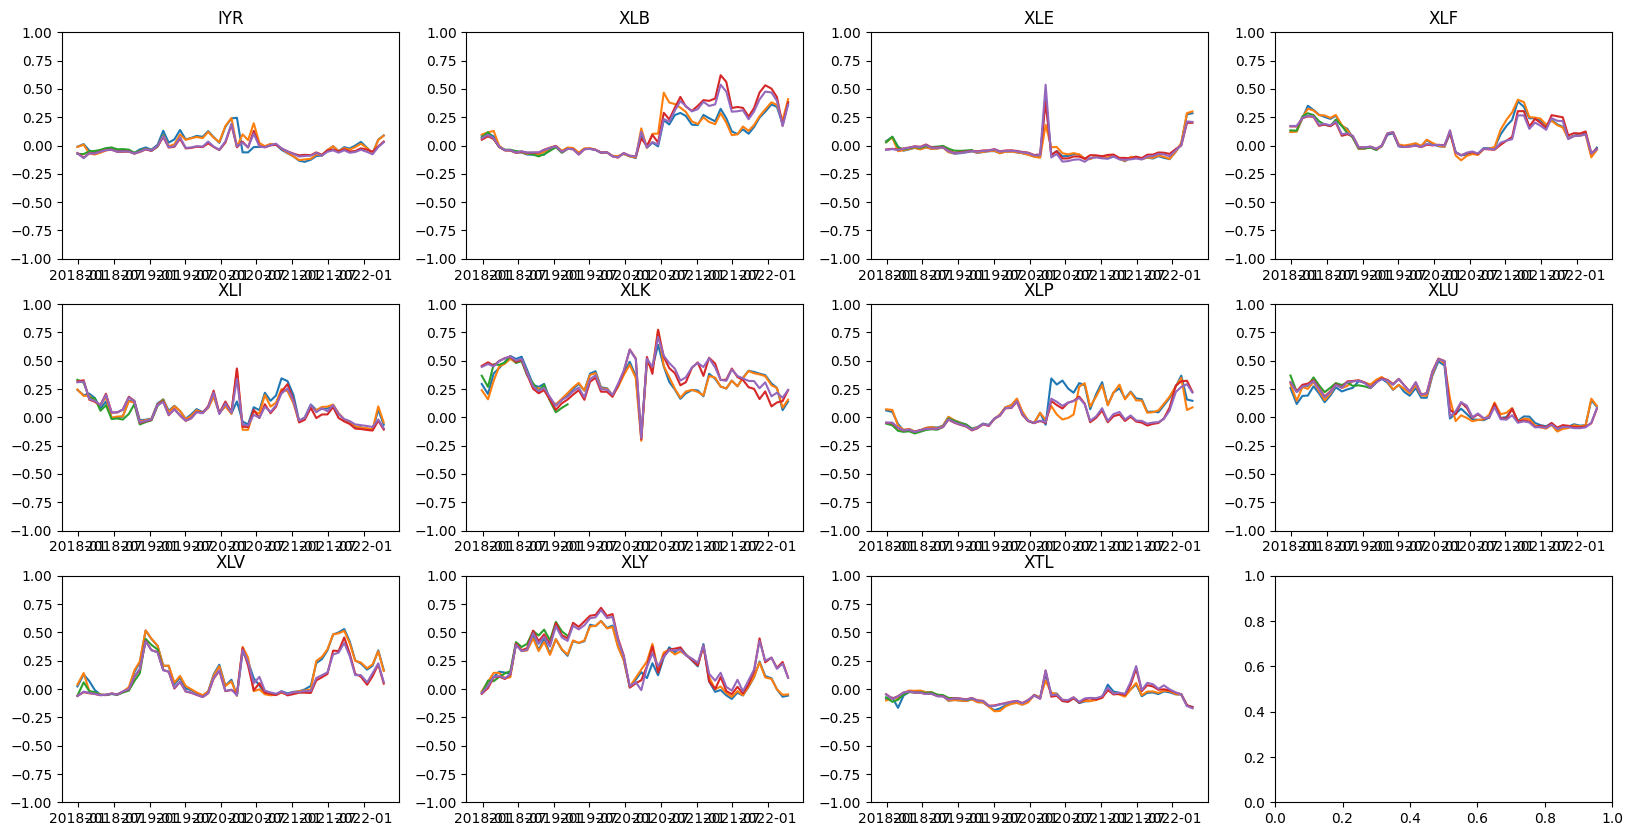

In [82]:
fig, ax = plt.subplots(3,4,figsize = (20,10))
k_n = 3
k_t = 3

w_t_s = np.array(t_port['ws_s'][k_n])
w_n_s = np.array(gaussian_port['ws_s'][k_t])
w_gt_s = np.array(gt_port['ws_s'][0])
w_cov_s = np.array(cov_port['ws_s'][0])
w_lw_s = np.array(LedoitWolf_port['ws_s'][0])

cnt = 0
for i in range(3):
    for j in range(4):
        if cnt == 11:
            break

        ax[i,j].plot(t_port['time_change'], w_t_s[:,cnt], label = 't')
        ax[i,j].plot(gaussian_port['time_change'], w_n_s[:,cnt], label = 'n')
        ax[i,j].plot(gt_port['time_change'][:len(w_gt_s[:,cnt])], w_gt_s[:,cnt], label = 'gt')
        ax[i,j].plot(cov_port['time_change'], w_cov_s[:,cnt], label = 'cov')
        ax[i,j].plot(LedoitWolf_port['time_change'], w_lw_s[:,cnt], label = 'lw')
        ax[i,j].set_title(t_port['X'].columns[cnt])
        ax[i,j].set_ylim((-1,1))

        cnt +=1




### plot cumulative return

In [3]:
import yfinance as yf

ticker_list = ['^GSPC']
groups = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2016-01-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]

[*********************100%***********************]  1 of 1 completed


In [4]:
import yfinance as yf

ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
start_date= "2016-01-01"
end_date="2023-02-01"

data_etf = yf.download(ticker_list, start_date , end_date)
data_etf_u = data_etf['Adj Close'].sum(axis=1)/data_etf.shape[1]

log_returns_etf = np.log(1+data_etf['Adj Close'].pct_change()).dropna()
log_returns_etf_scaled = 100*log_returns_etf.copy()#scaler.fit_transform(log_returns)
price_etf = data_etf['Adj Close'].iloc[1:]
price_etf_u = price_etf.sum(axis=1)/price_etf.shape[1]

[*********************100%***********************]  11 of 11 completed


In [10]:
def cum_prod_port(x):
    return np.cumprod(np.concatenate([(1+pd.DataFrame(x[i]).pct_change()).dropna() for i in range(len(x))]))


Compare static

In [ ]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port_no_w = pickle.load(handle)
    static_gaussian_port_no_w_out = extract_info(static_gaussian_port_no_w, 'gaussian', False)
    
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port_no_w = pickle.load(handle)

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)

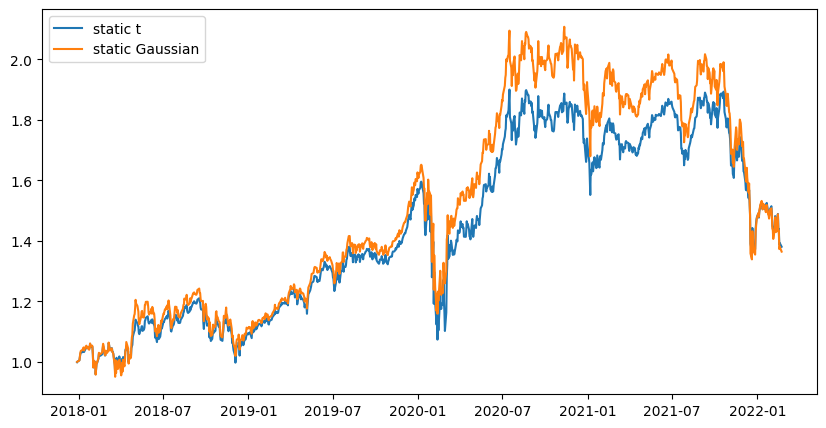

In [77]:


k = 3
s_t_price_no_w = cum_prod_port(static_t_port_no_w['port_price_s'][k]) 
s_n_price_no_w = cum_prod_port(static_gaussian_port_no_w['port_price_s'][k]) 
s_t_price = cum_prod_port(static_t_port['port_price_s'][k]) 
s_n_price = cum_prod_port(static_gaussian_port['port_price_s'][k]) 
#s_gt_price = cum_prod_port(static_gt_port['port_price_s'][0]) 


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price)], s_t_price, label = 'static t')
ax.plot(np.concatenate(static_gaussian_port['time_forecast'][0])[:len(s_n_price)], s_n_price, label = 'static Gaussian')
#ax.plot(np.concatenate(static_t_port_no_w['time_forecast'][0])[:len(s_t_price_no_w)], s_t_price_no_w, label = 'static t _no_w')
#ax.plot(np.concatenate(static_gaussian_port_no_w['time_forecast'][0])[:len(s_n_price_no_w)], s_n_price_no_w, label = 'static Gaussian _no_w')
#ax.plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price)], s_gt_price, label = 'static gt')
ax.legend()

Compare Dynamic

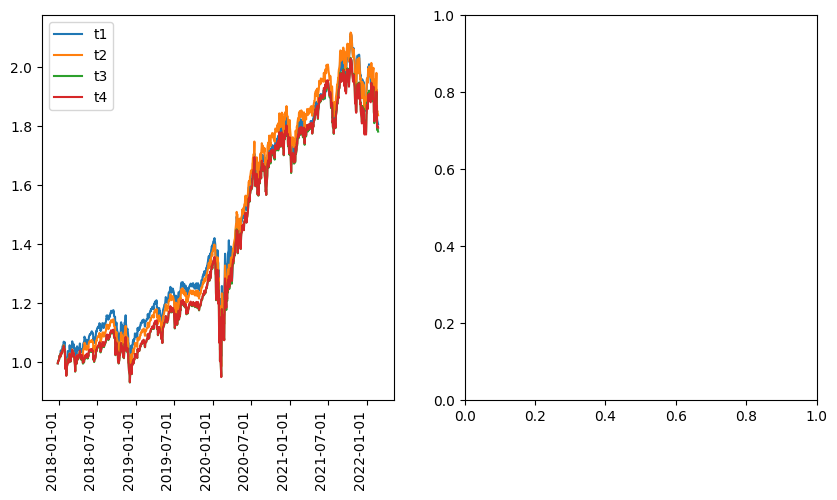

In [20]:
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_20.pkl', 'rb') as handle:
    t_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.3_disjoint_20.pkl', 'rb') as handle:
    t_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.4_disjoint_20.pkl', 'rb') as handle:
    t_port3 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.5_disjoint_20.pkl', 'rb') as handle:
    t_port4 = pickle.load(handle)

# with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.1_disjoint_50.pkl', 'rb') as handle:
#     gaussian_port1 = pickle.load(handle)
# with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.3_disjoint_50.pkl', 'rb') as handle:
#     gaussian_port2 = pickle.load(handle)
# with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.4_disjoint_50.pkl', 'rb') as handle:
#     gaussian_port3 = pickle.load(handle)
# with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_0.5_disjoint_50.pkl', 'rb') as handle:
#     gaussian_port4 = pickle.load(handle)

k = 3
s_t_price1 = cum_prod_port(t_port1['port_price_s'][k]) 
s_t_price2 = cum_prod_port(t_port2['port_price_s'][k]) 
s_t_price3 = cum_prod_port(t_port3['port_price_s'][k]) 
s_t_price4 = cum_prod_port(t_port4['port_price_s'][k]) 

# s_n_price1 = cum_prod_port(gaussian_port1['port_price_s'][k]) 
# s_n_price2 = cum_prod_port(gaussian_port2['port_price_s'][k]) 
# s_n_price3 = cum_prod_port(gaussian_port3['port_price_s'][k]) 
# s_n_price4 = cum_prod_port(gaussian_port4['port_price_s'][k]) 

fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].plot(np.concatenate(t_port1['time_forecast'][0])[:len(s_t_price1)], s_t_price1, label = 't1')
ax[0].plot(np.concatenate(t_port2['time_forecast'][0])[:len(s_t_price2)], s_t_price2, label = 't2')
ax[0].plot(np.concatenate(t_port3['time_forecast'][0])[:len(s_t_price3)], s_t_price3, label = 't3')
ax[0].plot(np.concatenate(t_port4['time_forecast'][0])[:len(s_t_price4)], s_t_price4, label = 't4')

#ax[0].plot(np.concatenate(gaussian_port1['time_forecast'][0])[:len(s_n_price1)], s_n_price1, label = 'gaussian1')
#ax[0].plot(np.concatenate(gaussian_port2['time_forecast'][0])[:len(s_n_price2)], s_n_price2, label = 'gaussian2')
#ax[0].plot(np.concatenate(gaussian_port3['time_forecast'][0])[:len(s_n_price3)], s_n_price3, label = 'gaussian3')
#ax[0].plot(np.concatenate(gaussian_port4['time_forecast'][0])[:len(s_n_price4)], s_n_price4, label = 'gaussian4')

#ax[0].plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_port)], s_gt_port, label = 'Static Group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')
#ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


ax[0].legend()

 Compare Dynamic Penalty

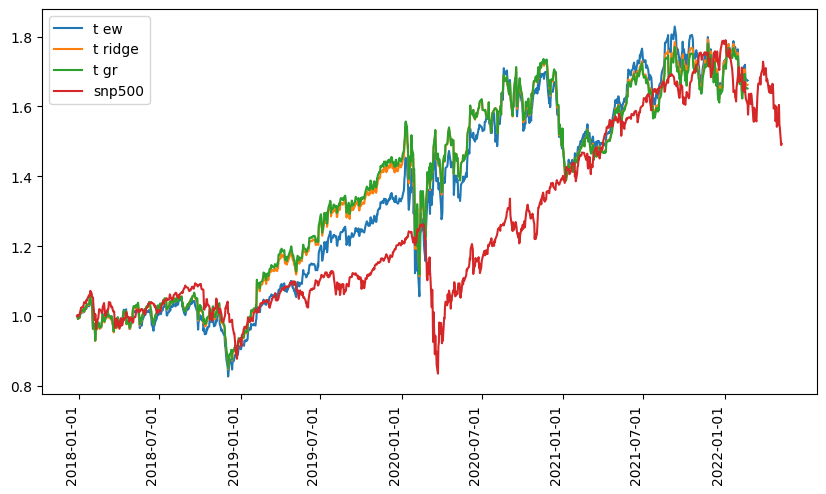

In [243]:
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.2_disjoint_20.pkl', 'rb') as handle:
    t_ew = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.2_disjoint_20_ridge.pkl', 'rb') as handle:
    t_ridge = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_0.2_disjoint_20_global-reconstruction.pkl', 'rb') as handle:
    t_gr = pickle.load(handle)


with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.2_disjoint_20.pkl', 'rb') as handle:
    n_ew = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.2_disjoint_20_ridge.pkl', 'rb') as handle:
    n_ridge = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_0.2_disjoint_20_global-reconstruction.pkl', 'rb') as handle:
    n_gr = pickle.load(handle)

k = 3
s_t_ew = cum_prod_port(t_ew['port_price_s'][k]) 
s_t_ridge = cum_prod_port(t_ridge['port_price_s'][k]) 
s_t_gr = cum_prod_port(t_gr['port_price_s'][k]) 

s_n_ew = cum_prod_port(n_ew['port_price_s'][k]) 
s_n_ridge = cum_prod_port(n_ridge['port_price_s'][k]) 
s_n_gr = cum_prod_port(n_gr['port_price_s'][k]) 

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.concatenate(t_ew['time_forecast'][0])[:len(s_t_ew)], s_t_ew, label = 't ew')
ax.plot(np.concatenate(t_ridge['time_forecast'][0])[:len(s_t_ridge)], s_t_ridge, label = 't ridge')
ax.plot(np.concatenate(t_gr['time_forecast'][0])[:len(s_t_gr)], s_t_gr, label = 't gr')


#ax.plot(np.concatenate(n_ew['time_forecast'][0])[:len(s_n_ew)], s_n_ew, label = 'gaussian ew')
#ax.plot(np.concatenate(n_ridge['time_forecast'][0])[:len(s_n_ridge)], s_n_ridge, label = 'gaussian ridge')
#ax.plot(np.concatenate(n_gr['time_forecast'][0])[:len(s_n_gr)], s_n_gr, label = 'gaussian gr')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


ax.legend()

Compare alpha level

In [155]:
def plot_per_alpha(port):
    fig, ax = plt.subplots(1,1,figsize = (10,5))

    for cnt, alpha in enumerate(port['alphas']):
        if len(port['port_price_s'][cnt])<=0:
            continue
        s_price = cum_prod_port(port['port_price_s'][cnt]) 
        ax.plot(np.concatenate(port['time_forecast'][0])[:len(s_price)], s_price, label = f't {cnt}')


    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    #ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


    ax.legend()

C:\Users\User\AppData\Local\Temp\ipykernel_20732\2020302815.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


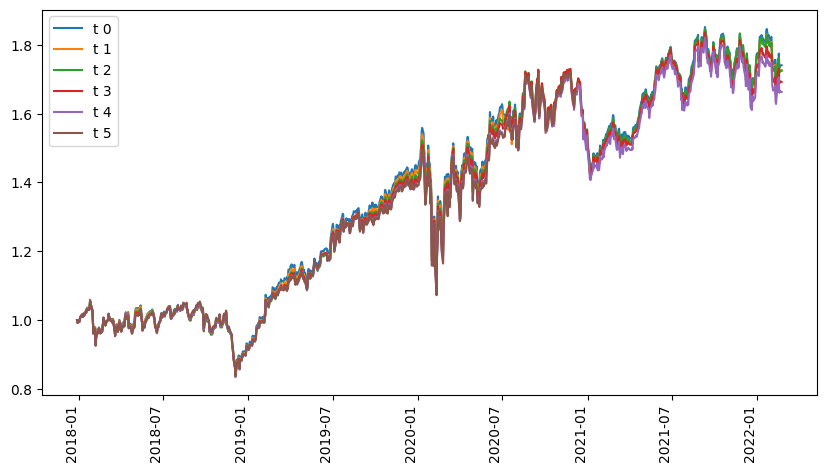

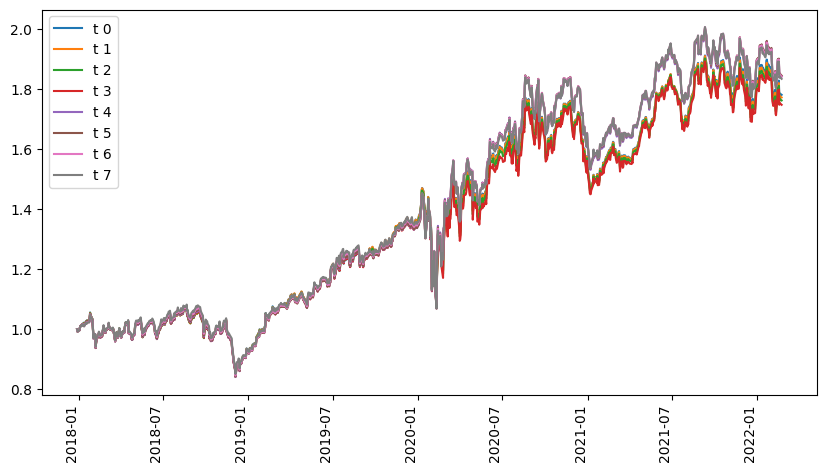

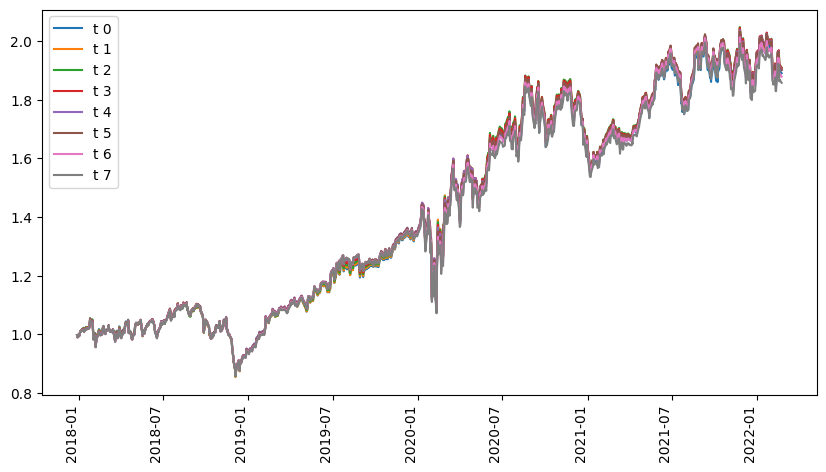

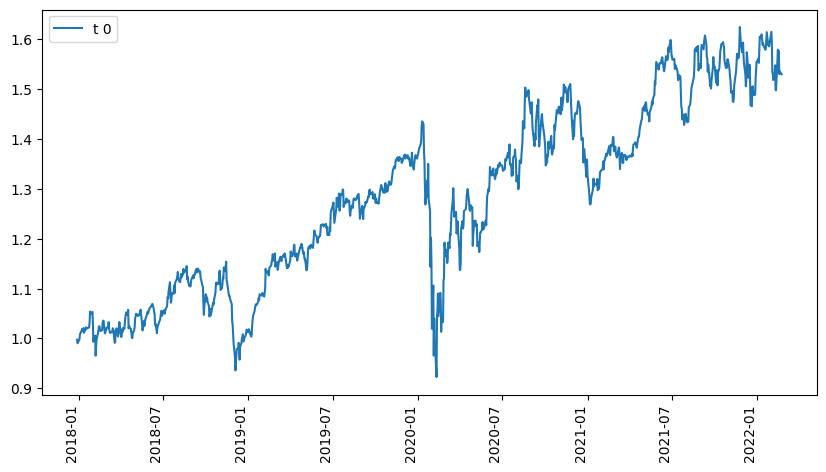

In [159]:


with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.1}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.5}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{1}_disjoint_20.pkl', 'rb') as handle:
    port = pickle.load(handle)
plot_per_alpha(port)

C:\Users\User\AppData\Local\Temp\ipykernel_20732\2020302815.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


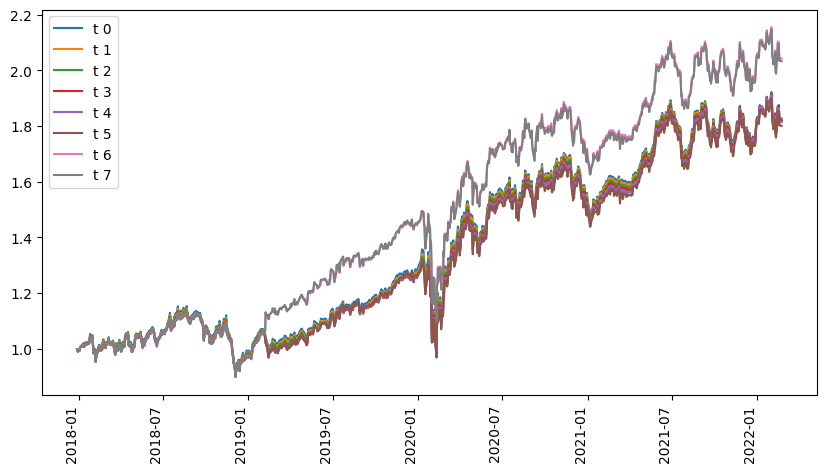

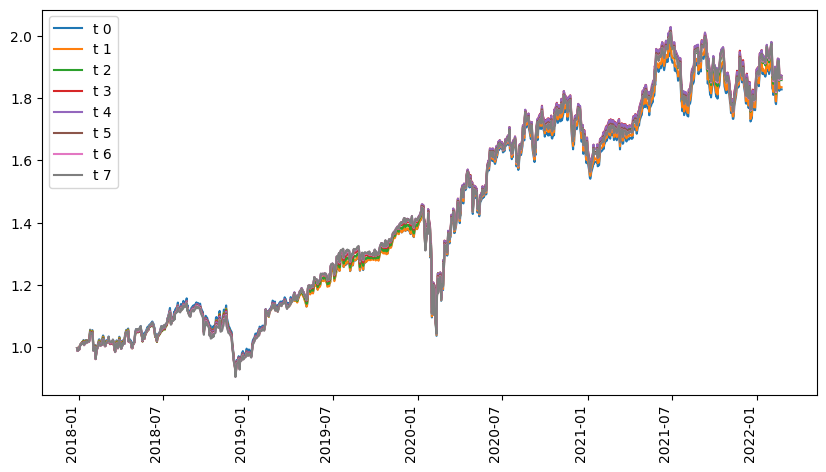

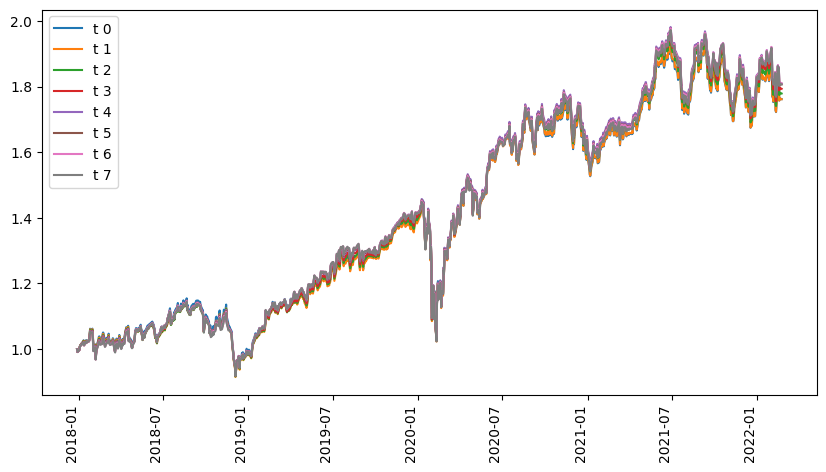

In [206]:
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.1}_disjoint_50.pkl', 'rb') as handle:
    port1 = pickle.load(handle)
plot_per_alpha(port1)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_50.pkl', 'rb') as handle:
    port2 = pickle.load(handle)
plot_per_alpha(port2)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.5}_disjoint_50.pkl', 'rb') as handle:
    port3 = pickle.load(handle)
plot_per_alpha(port3)


In [225]:
np.round(port3['thetas'][10][20][-1],2)

array([[ 0.61,  0.  , -0.01, -0.  , -0.  , -0.02, -0.  , -0.  , -0.01,
        -0.  , -0.  , -0.02, -0.02,  0.  , -0.05, -0.1 , -0.  ,  0.  ,
        -0.02, -0.01,  0.  , -0.02,  0.  ,  0.  ,  0.  ,  0.  , -0.01,
        -0.02, -0.  ,  0.  ],
       [ 0.  ,  0.98,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  , -0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  , -0.03, -0.38, -0.26, -0.  , -0.03,  0.  ,
         0.  ,  0.  ,  0.  ],
       [-0.01,  0.  ,  0.81, -0.  , -0.  , -0.04, -0.04, -0.01, -0.01,
        -0.  , -0.  , -0.03, -0.1 , -0.02, -0.04, -0.17,  0.  ,  0.  ,
        -0.04, -0.01, -0.  , -0.04,  0.  ,  0.  ,  0.  , -0.01, -0.  ,
        -0.02, -0.11, -0.  ],
       [-0.  ,  0.  , -0.  ,  0.28, -0.02, -0.  , -0.01, -0.  , -0.02,
        -0.  , -0.  , -0.04, -0.03, -0.  , -0.  , -0.04, -0.03,  0.  ,
        -0.  , -0.  , -0.01, -0.  ,  0.  ,  0.  ,  0.  , -0.01,  0.  ,
        -0.01, -0.  , -0.  ],
       [-0.  ,  0.  , -0.  ,

In [230]:
port3['fro_norms'][11]

[1.0868850329235066e-05,
 8.16083041572504e-06,
 6.305119966517903e-06,
 0.0648242145797843,
 6.453859940637246e-06,
 6.879004929818595e-06,
 4.0762005225143696e-05,
 0.10615099784192034,
 5.557794461410883e-06,
 0.06476067882008481,
 0.08703229073771207,
 0.0008053282527315887,
 8.965905918821836e-06,
 9.429229212181888e-06,
 7.430429045467448e-06,
 8.249220724460053e-06,
 1.3901355170722105e-05,
 8.639822469312907e-06,
 1.2187593452939597e-05,
 7.82818710023496e-06,
 8.640230116793925e-06,
 1.0343713180144122e-05,
 1.1149590004558042e-05,
 1.0812724484080347e-05,
 8.648326221502867e-06,
 7.864850785753312e-06,
 9.864651628249262e-06,
 8.291151025897484e-06,
 1.4319480110127503e-05,
 2.086041583120111e-05,
 1.7370197562072633e-05,
 1.9036267162486892e-05,
 2.5488725441411993e-05,
 2.0299321637644883e-05,
 2.2023257197434048e-05,
 1.8461968673482255e-05,
 1.6919812610153783e-05,
 1.656711662658576e-05,
 1.8770461056924743e-05,
 1.6824942808969313e-05,
 1.4587685218671017e-05,
 1.600384

In [233]:
scipy.linalg.norm(port3['thetas'][12][20][-1])

KeyError: 12

In [226]:
np.round(port3['thetas'][2][20][-1],2)

array([[ 1.08, -0.11, -0.  , -0.  ,  0.  , -0.05,  0.  ,  0.  , -0.01,
         0.  ,  0.  , -0.03, -0.05,  0.  , -0.11, -0.21, -0.01,  0.  ,
        -0.06, -0.01,  0.02, -0.09, -0.02,  0.  ,  0.03,  0.  , -0.02,
        -0.04, -0.02,  0.  ],
       [-0.11,  2.31, -0.07,  0.  ,  0.  ,  0.03,  0.  ,  0.  ,  0.03,
         0.  ,  0.02,  0.  , -0.09,  0.  ,  0.  ,  0.05,  0.  , -0.  ,
        -0.03,  0.  ,  0.  , -0.12, -1.15, -0.64,  0.  , -0.18,  0.  ,
         0.01,  0.  , -0.06],
       [-0.  , -0.07,  1.66,  0.  ,  0.  , -0.1 , -0.07, -0.02, -0.02,
        -0.01,  0.  , -0.05, -0.27, -0.01, -0.08, -0.38,  0.  ,  0.03,
        -0.12, -0.02,  0.  , -0.12,  0.  ,  0.  ,  0.  , -0.06,  0.  ,
        -0.02, -0.25, -0.03],
       [-0.  ,  0.  ,  0.  ,  0.43, -0.03, -0.  , -0.02, -0.  , -0.02,
        -0.01, -0.04, -0.07, -0.07,  0.  ,  0.02, -0.02, -0.07,  0.01,
         0.03, -0.  , -0.01,  0.  ,  0.05,  0.02,  0.  , -0.05, -0.02,
        -0.03, -0.  , -0.01],
       [ 0.  ,  0.  ,  0.  ,

C:\Users\User\AppData\Local\Temp\ipykernel_20732\2020302815.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


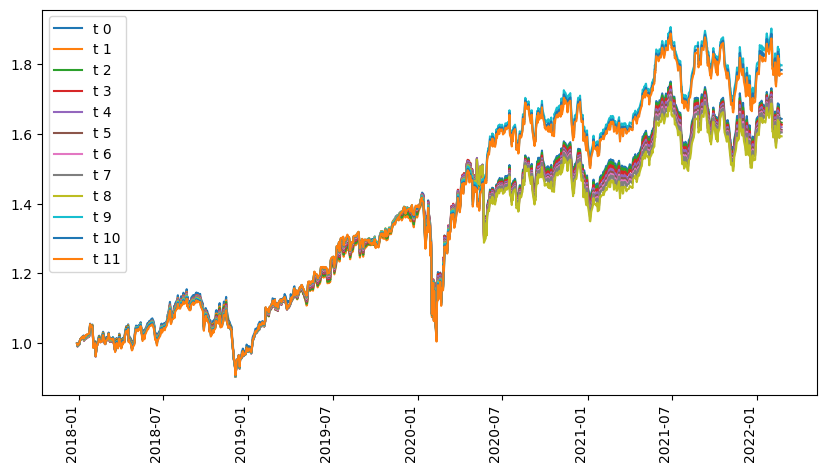

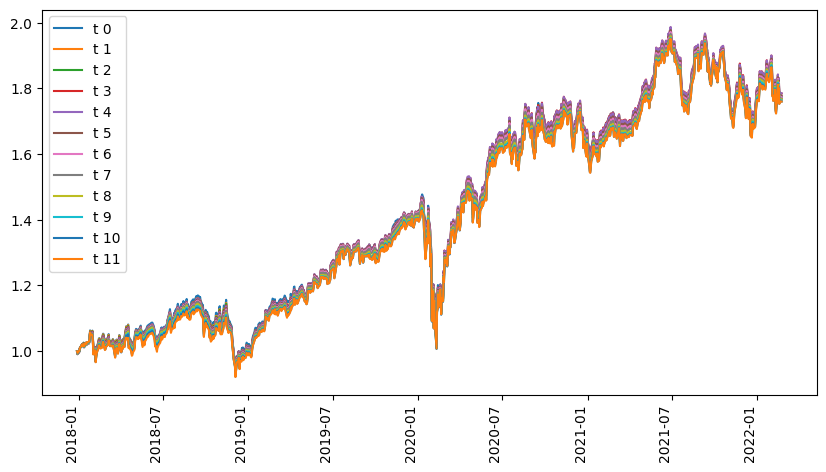

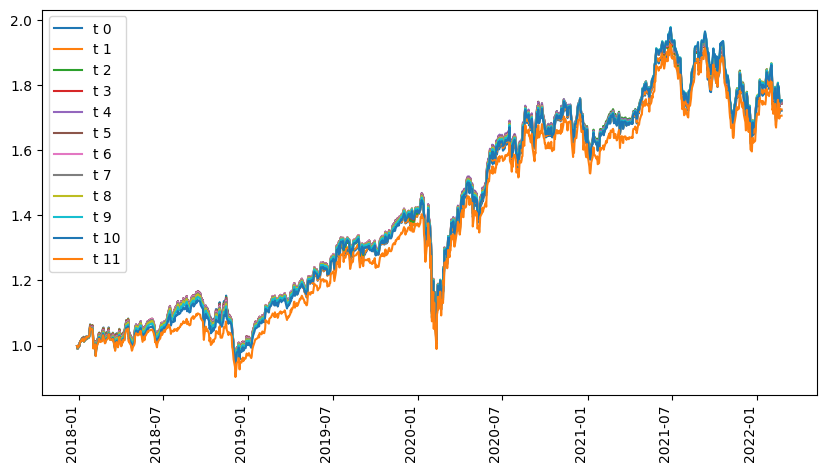

In [221]:
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.1}_disjoint_100.pkl', 'rb') as handle:
    port1 = pickle.load(handle)
plot_per_alpha(port1)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_100.pkl', 'rb') as handle:
    port2 = pickle.load(handle)
plot_per_alpha(port2)

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.5}_disjoint_100.pkl', 'rb') as handle:
    port3 = pickle.load(handle)
plot_per_alpha(port3)

Compare different number of observations per graph

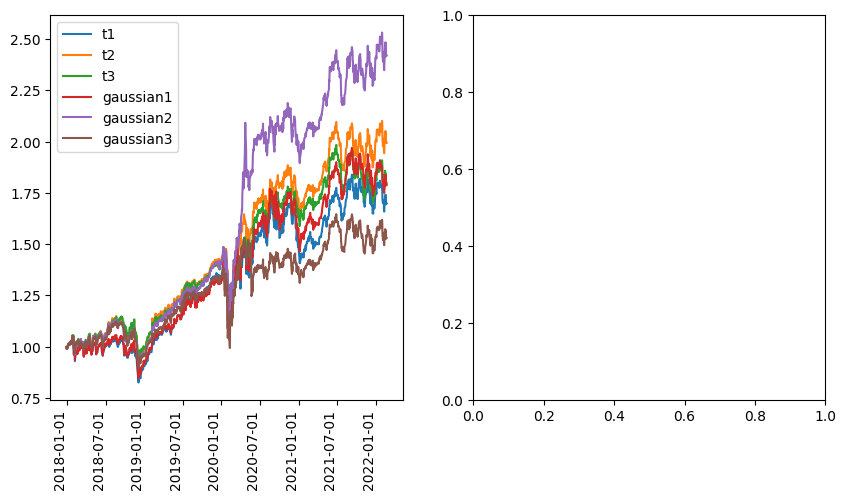

In [220]:
k = 0.2

with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_20.pkl', 'rb') as handle:
    t_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_50.pkl', 'rb') as handle:
    t_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_100.pkl', 'rb') as handle:
    t_port3 = pickle.load(handle)
#with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{k}_disjoint_250.pkl', 'rb') as handle:
#    t_port4 = pickle.load(handle)

with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_20.pkl', 'rb') as handle:
    gaussian_port1 = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_50.pkl', 'rb') as handle:
    gaussian_port2 = pickle.load(handle)
with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_100.pkl', 'rb') as handle:
    gaussian_port3 = pickle.load(handle)
#with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_k_{k}_disjoint_250.pkl', 'rb') as handle:
#    gaussian_port4 = pickle.load(handle)



a = 2
s_t_price1 = cum_prod_port(t_port1['port_price_s'][a]) 
s_t_price2 = cum_prod_port(t_port2['port_price_s'][a]) 
s_t_price3 = cum_prod_port(t_port3['port_price_s'][a]) 
s_t_price4 = cum_prod_port(t_port4['port_price_s'][a]) 

s_n_price1 = cum_prod_port(gaussian_port1['port_price_s'][a]) 
s_n_price2 = cum_prod_port(gaussian_port2['port_price_s'][a]) 
s_n_price3 = cum_prod_port(gaussian_port3['port_price_s'][a]) 
s_n_price4 = cum_prod_port(gaussian_port4['port_price_s'][a]) 

fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].plot(np.concatenate(t_port1['time_forecast'][0])[:len(s_t_price1)], s_t_price1, label = 't1')
ax[0].plot(np.concatenate(t_port2['time_forecast'][0])[:len(s_t_price2)], s_t_price2, label = 't2')
ax[0].plot(np.concatenate(t_port3['time_forecast'][0])[:len(s_t_price3)], s_t_price3, label = 't3')
#ax[0].plot(np.concatenate(t_port4['time_forecast'][0])[:len(s_t_price4)], s_t_price4, label = 't4')

ax[0].plot(np.concatenate(gaussian_port1['time_forecast'][0])[:len(s_n_price1)], s_n_price1, label = 'gaussian1')
ax[0].plot(np.concatenate(gaussian_port2['time_forecast'][0])[:len(s_n_price2)], s_n_price2, label = 'gaussian2')
ax[0].plot(np.concatenate(gaussian_port3['time_forecast'][0])[:len(s_n_price3)], s_n_price3, label = 'gaussian3')
#ax[0].plot(np.concatenate(gaussian_port4['time_forecast'][0])[:len(s_n_price4)], s_n_price4, label = 'gaussian4')

#ax[0].plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_port)], s_gt_port, label = 'Static Group t')
ax[0].set_xticks(ax[0].get_xticks())
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='right')
#ax[0].plot(np.cumprod(1+data['Adj Close'].pct_change()[500:1600]), label = 'snp500')


ax[0].legend()

Compare best

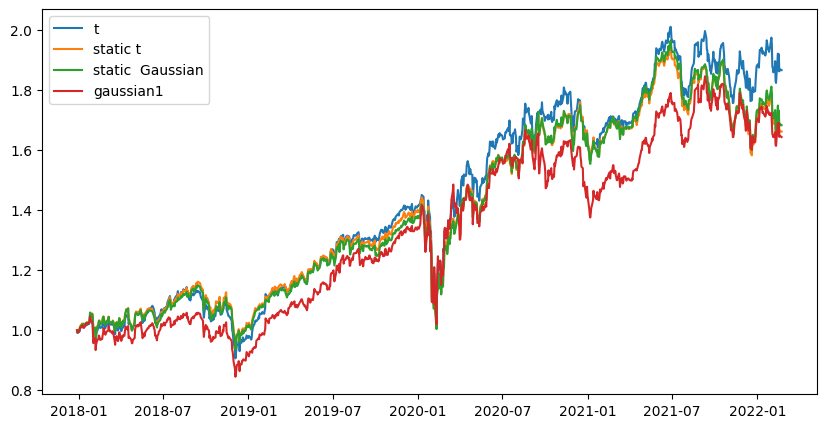

In [173]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_ind_30_k_{0.3}_disjoint_50.pkl', 'rb') as handle:
    t_port1 = pickle.load(handle)


t_price = cum_prod_port(t_port1['port_price_s'][7]) 
s_t_price = cum_prod_port(static_t_port['port_price_s'][6]) 
s_n_price = cum_prod_port(static_gaussian_port['port_price_s'][6]) 


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(np.concatenate(t_port1['time_forecast'][0])[:len(t_price)], t_price, label = 't')
ax.plot(np.concatenate(static_t_port['time_forecast'][0])[:len(s_t_price)], s_t_price, label = 'static t')
ax.plot(np.concatenate(static_gaussian_port['time_forecast'][0])[:len(s_n_price)], s_n_price, label = 'static  Gaussian')
#ax[0].plot(np.concatenate(t_port3['time_forecast'][0])[:len(s_t_price3)], s_t_price3, label = 't3')
#ax[0].plot(np.concatenate(t_port4['time_forecast'][0])[:len(s_t_price4)], s_t_price4, label = 't4')

ax.plot(np.concatenate(gaussian_port1['time_forecast'][0])[:len(s_n_price1)], s_n_price1, label = 'gaussian1')
ax.legend()

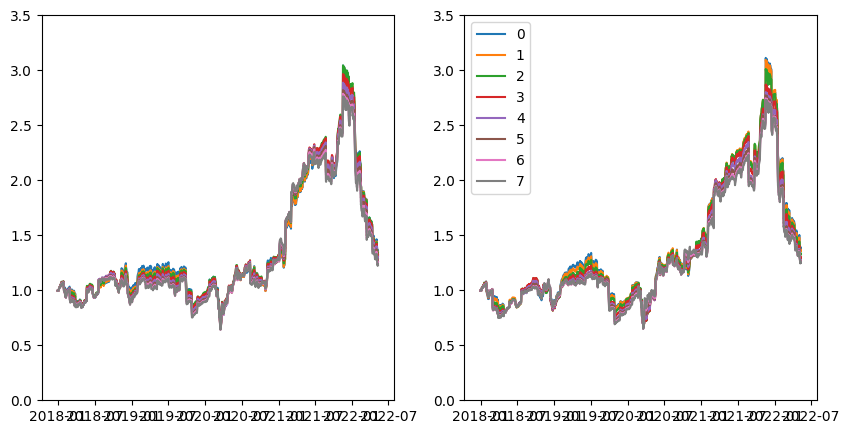

In [307]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
k = 0
for i in range(len(t_port['alphas'])):
    ax[0].plot(np.concatenate(t_port['time_forecast'][i])[1:], np.cumprod(1+pd.DataFrame(np.concatenate(t_port['port_price_s'][i])).pct_change().dropna()), label = i)
    ax[0].set_ylim((0,3.5))
for i in range(len(t_port['alphas'])):
    ax[1].plot(np.concatenate(gaussian_port['time_forecast'][i])[1:], np.cumprod(1+pd.DataFrame(np.concatenate(gaussian_port['port_price_s'][i])).pct_change().dropna()), label = i)
    ax[1].set_ylim((0,3.5))

ax[1].legend()

### Plot variance

static

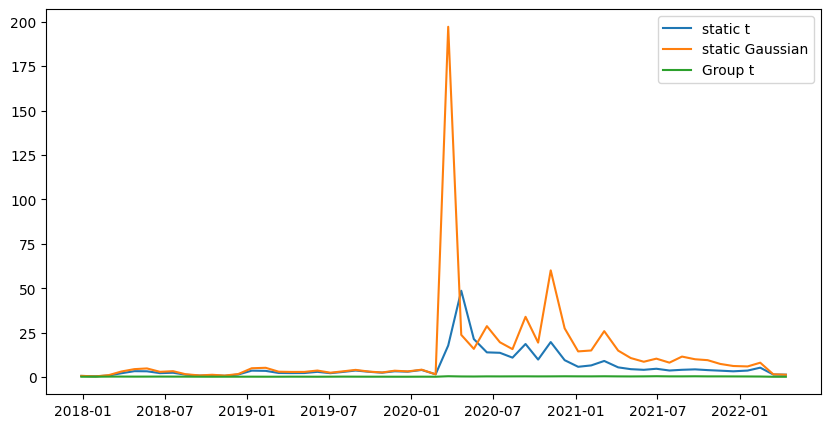

In [15]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)

k = 2

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_t_port['time_change'], static_t_port['vars_s'][k], label = 'static t')
ax.plot(static_gaussian_port['time_change'], static_gaussian_port['vars_s'][k], label = 'static Gaussian')
ax.plot(static_gt_port['time_change'][:len(static_gt_port['vars_s'][0])], static_gt_port['vars_s'][0], label = 'Group t')
#ax.plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price)], s_gt_price, label = 'static gt')
ax.legend()

alpha static

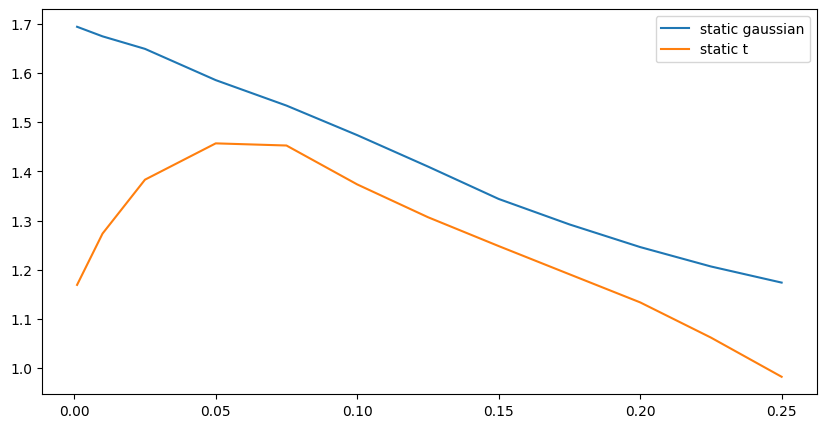

In [22]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['vars_s'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['vars_s'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.legend()


Compare dynamic

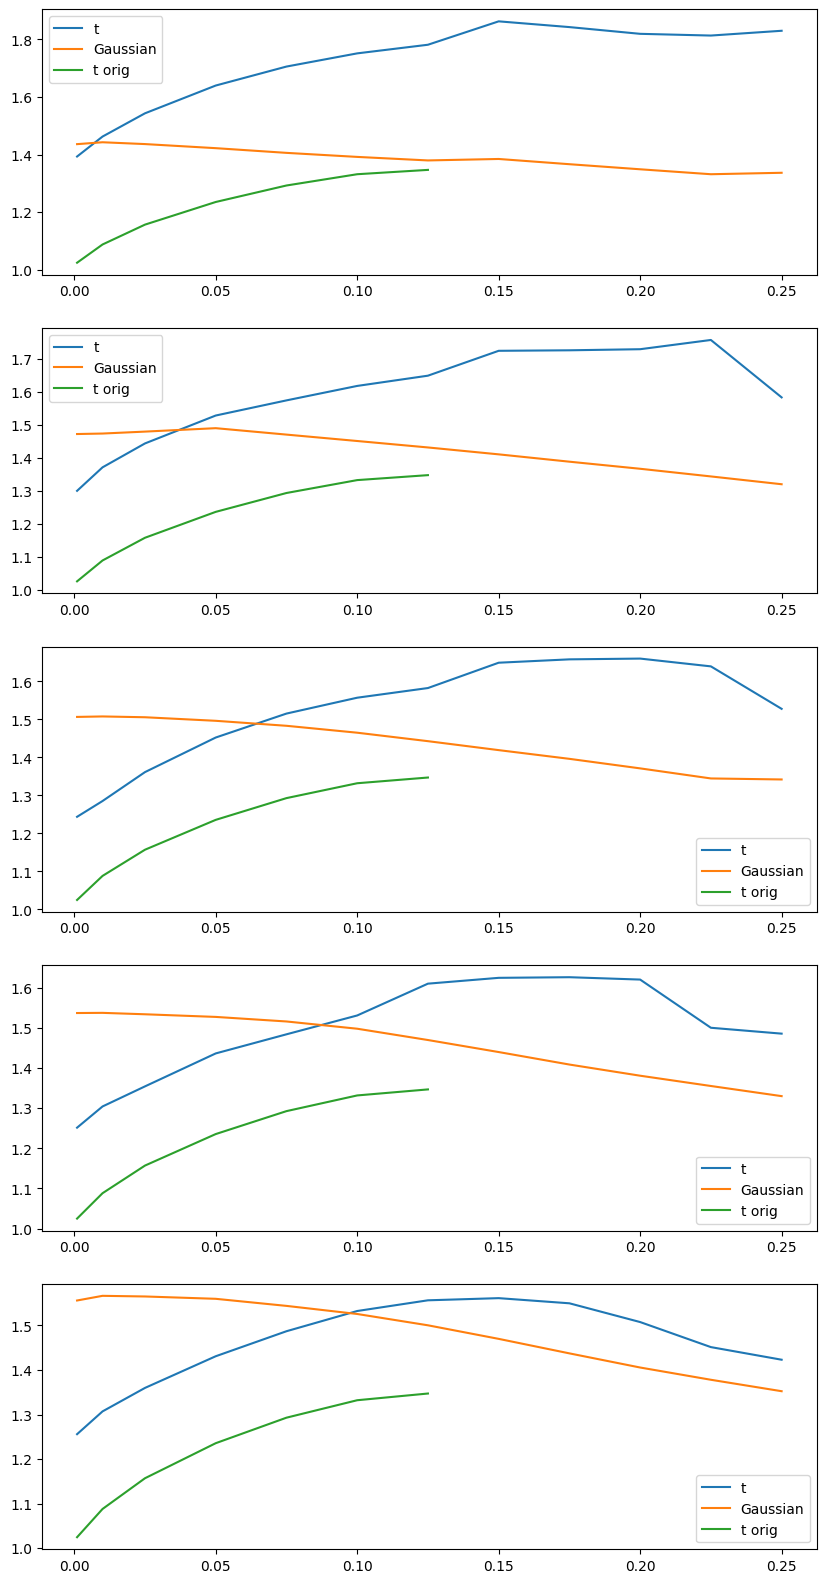

In [47]:
t_port = []
t_orig_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_50.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['vars_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['vars_s'][cnt]))
    
    n_port.append(mean_mdd_n)


    with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        t_portorig = pickle.load(handle)
    mean_mdd_t_orig = []
    for cnt, alpha in enumerate(t_portorig['alphas']):
        mean_mdd_t_orig.append(np.mean(t_portorig['vars_s'][cnt]))
    t_orig_port.append(mean_mdd_t_orig)




fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')
    ax[cnt].plot(t_portorig['alphas'][:len(t_orig_port[cnt])], t_orig_port[cnt], label = f't orig')

    ax[cnt].legend()


Compare temporal

In [58]:


with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_50.pkl', 'rb') as handle:
    t_port_ew = pickle.load(handle)

with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_50_ridge.pkl', 'rb') as handle:
    t_port_ridge = pickle.load(handle)


with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_0.1_disjoint_50_global-reconstruction.pkl', 'rb') as handle:
    t_port_gr = pickle.load(handle)

mean_mdd_ew = []
for cnt, alpha in enumerate(t_port_ew['alphas']):
    mean_mdd_ew.append(np.mean(t_port_ew['vars_s'][cnt]))
mean_mdd_ridge = []
for cnt, alpha in enumerate(t_port_ridge['alphas']):
    mean_mdd_ridge.append(np.mean(t_port_ridge['vars_s'][cnt]))
mean_mdd_gr = []
for cnt, alpha in enumerate(t_port_gr['alphas']):
    mean_mdd_gr.append(np.mean(t_port_gr['vars_s'][cnt]))


fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.plot(t_port_ew['alphas'], mean_mdd_ew, label = f'ew')
ax.plot(t_port_ridge['alphas'], mean_mdd_ridge, label = f'ridge')
ax.plot(t_port_gr['alphas'], mean_mdd_gr, label = f'gr')


ax.legend()

FileNotFoundError: [Errno 2] No such file or directory: '../data/case_study_etf/t_nr_quad_10_ind_30_k_0.1_disjoint_50_ridge.pkl'

### Plot return

Static return

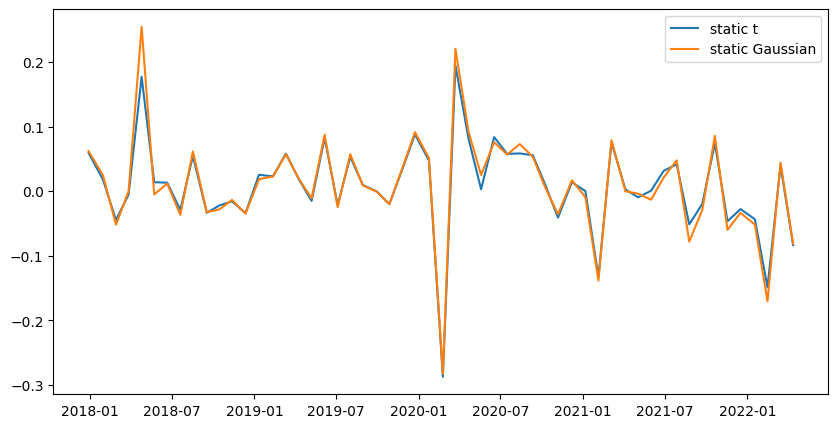

In [20]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

with open(f'../data/case_study_etf/group-t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gt_port = pickle.load(handle)

k = 1

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_t_port['time_change'], static_t_port['rs_s'][k], label = 'static t')
ax.plot(static_gaussian_port['time_change'], static_gaussian_port['rs_s'][k], label = 'static Gaussian')
#ax.plot(static_gt_port['time_change'][:len(static_gt_port['rs_s'][0])], static_gt_port['rs_s'][0], label = 'Group t')
#ax.plot(np.concatenate(static_gt_port['time_forecast'][0])[:len(s_gt_price)], s_gt_price, label = 'static gt')
ax.legend()

static return per alpha

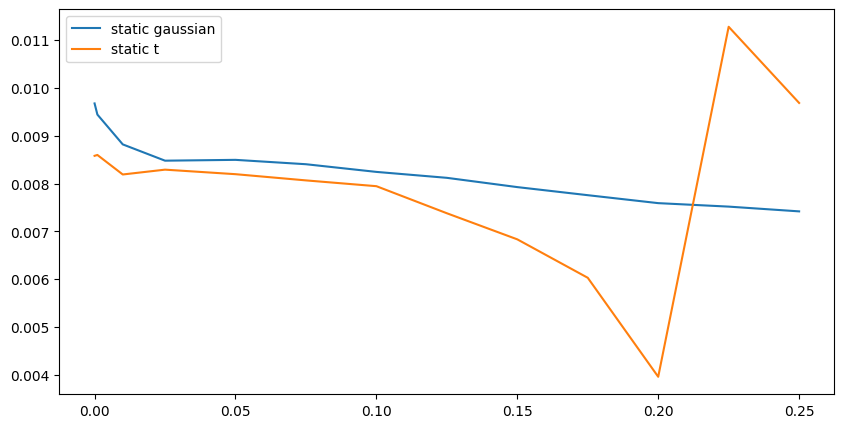

In [21]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['rs_s'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['rs_s'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.legend()




Dynamic

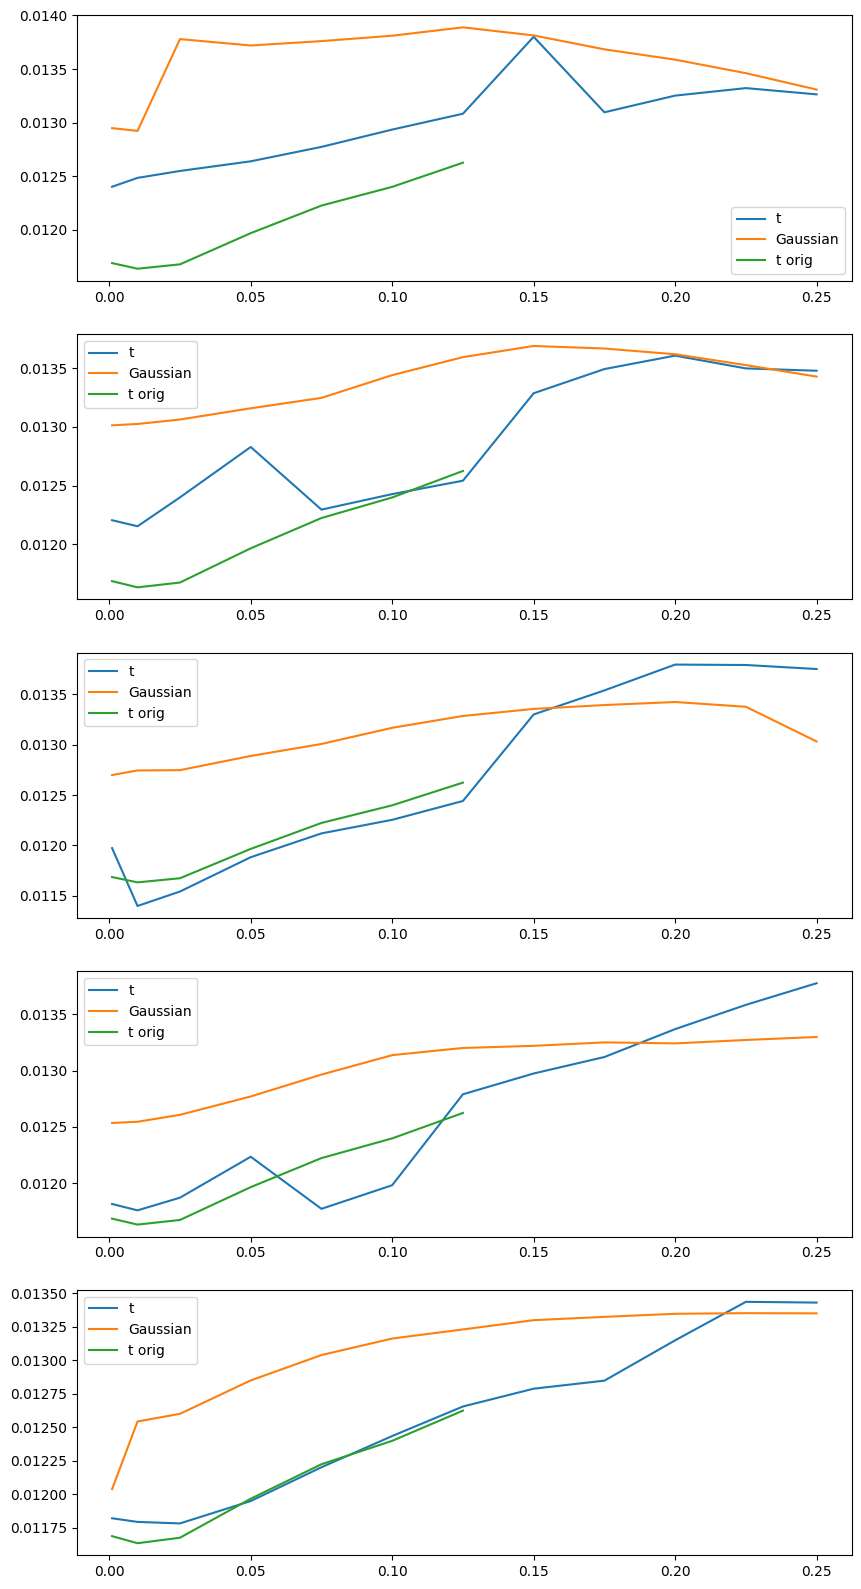

In [48]:
t_port = []
t_orig_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_50.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['rs_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['rs_s'][cnt]))
    
    n_port.append(mean_mdd_n)


    with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        t_portorig = pickle.load(handle)
    mean_mdd_t_orig = []
    for cnt, alpha in enumerate(t_portorig['alphas']):
        mean_mdd_t_orig.append(np.mean(t_portorig['rs_s'][cnt]))
    t_orig_port.append(mean_mdd_t_orig)




fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')
    ax[cnt].plot(t_portorig['alphas'][:len(t_orig_port[cnt])], t_orig_port[cnt], label = f't orig')

    ax[cnt].legend()


### Plot sharpe

static sharpe

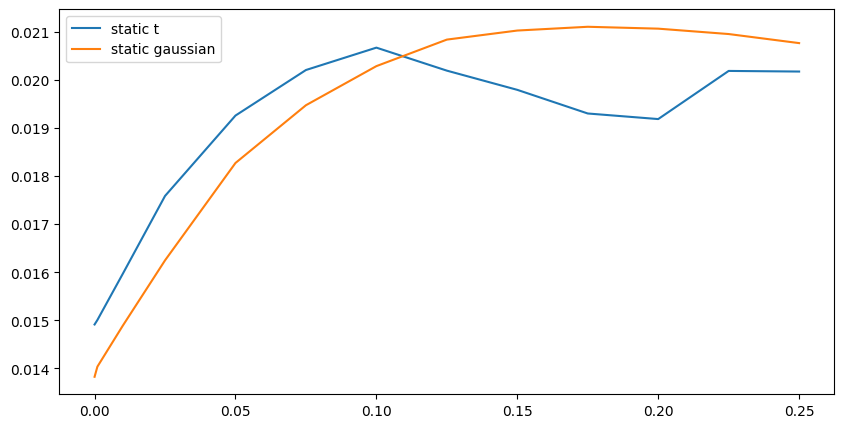

In [35]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['sharpes_s'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['sharpes_s'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.legend()





dynamic

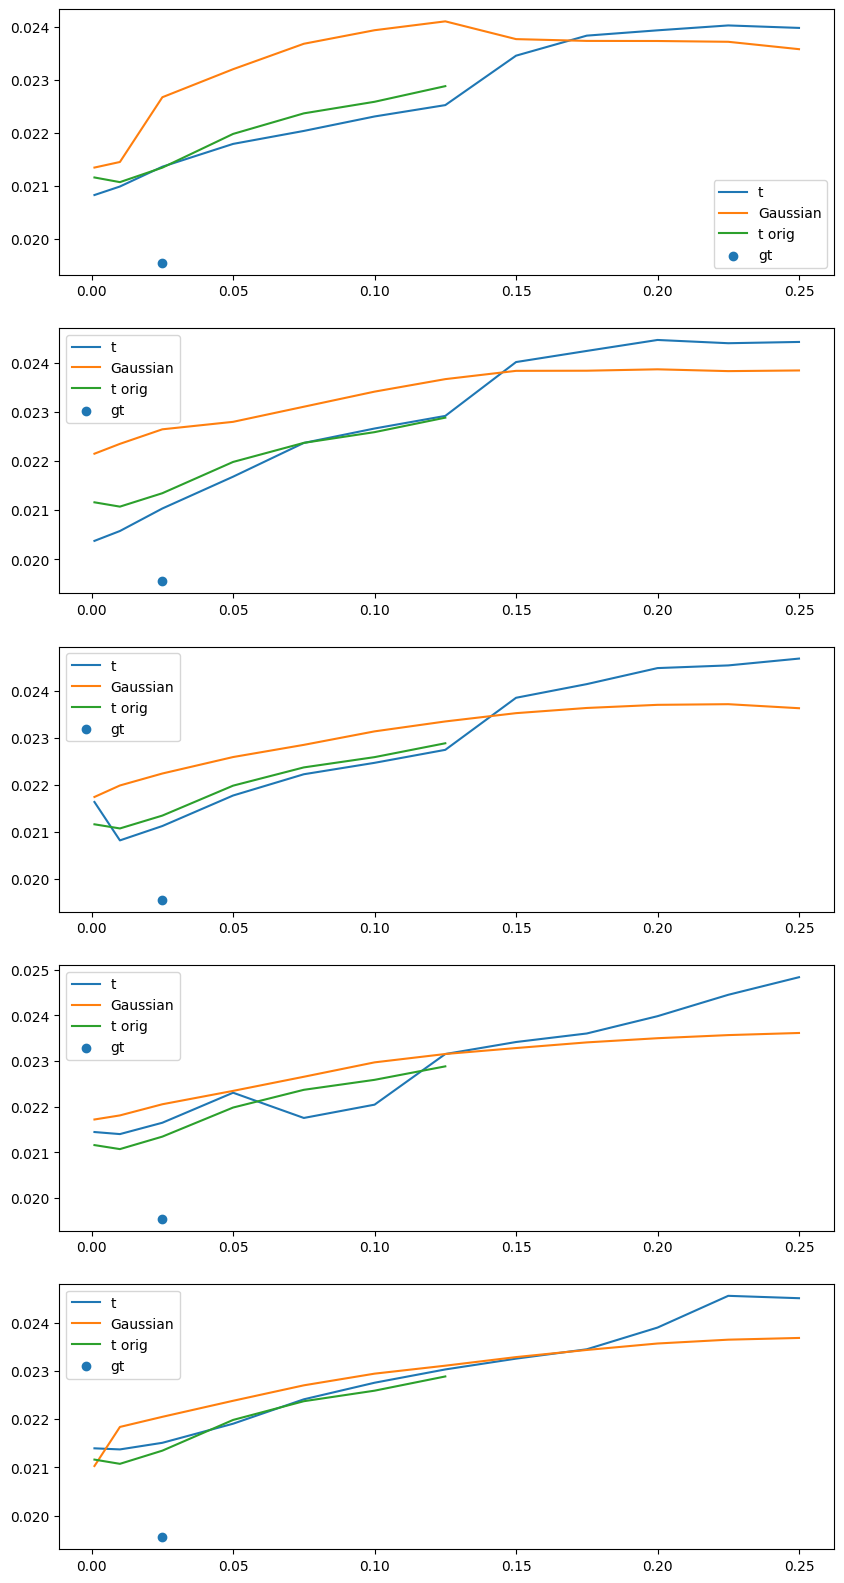

In [55]:
t_port = []
gt_port = []
t_orig_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_50.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['sharpes_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['sharpes_s'][cnt]))
    
    n_port.append(mean_mdd_n)


    with open(f'../data/case_study_etf/t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        t_portorig = pickle.load(handle)
    mean_mdd_t_orig = []
    for cnt, alpha in enumerate(t_portorig['alphas']):
        mean_mdd_t_orig.append(np.mean(t_portorig['sharpes_s'][cnt]))
    t_orig_port.append(mean_mdd_t_orig)

    with open(f'../data/case_study_etf/group-t_kappa_0.9_nr_quad_10_etf.pkl', 'rb') as handle:
        gt_port1 = pickle.load(handle)
    mean_mdd_gt = []
    for cnt, alpha in enumerate(gt_port1['alphas']):
        mean_mdd_gt.append(np.mean(gt_port1['sharpes_s'][cnt]))
    gt_port.append(mean_mdd_gt)






fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')
    ax[cnt].plot(t_portorig['alphas'][:len(t_orig_port[cnt])], t_orig_port[cnt], label = f't orig')
    ax[cnt].scatter(gt_port1['alphas'][:len(gt_port[cnt])], gt_port[cnt], label = f'gt')

    ax[cnt].legend()


### Plot omegas

static

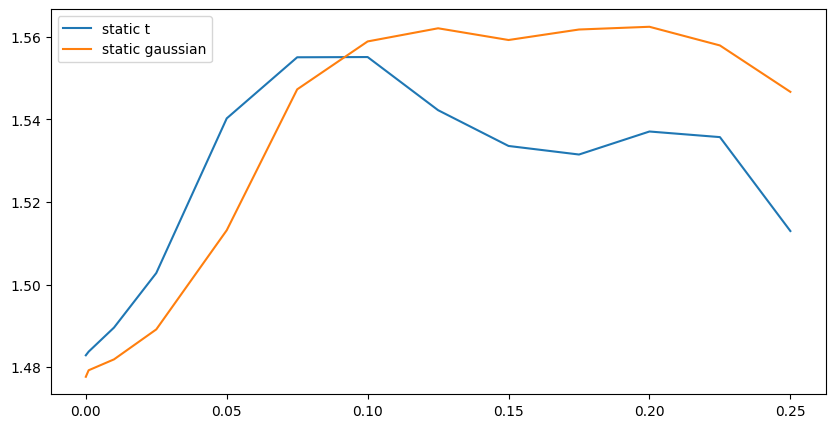

In [31]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['omegas_s'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['omegas_s'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.legend()





dynamic

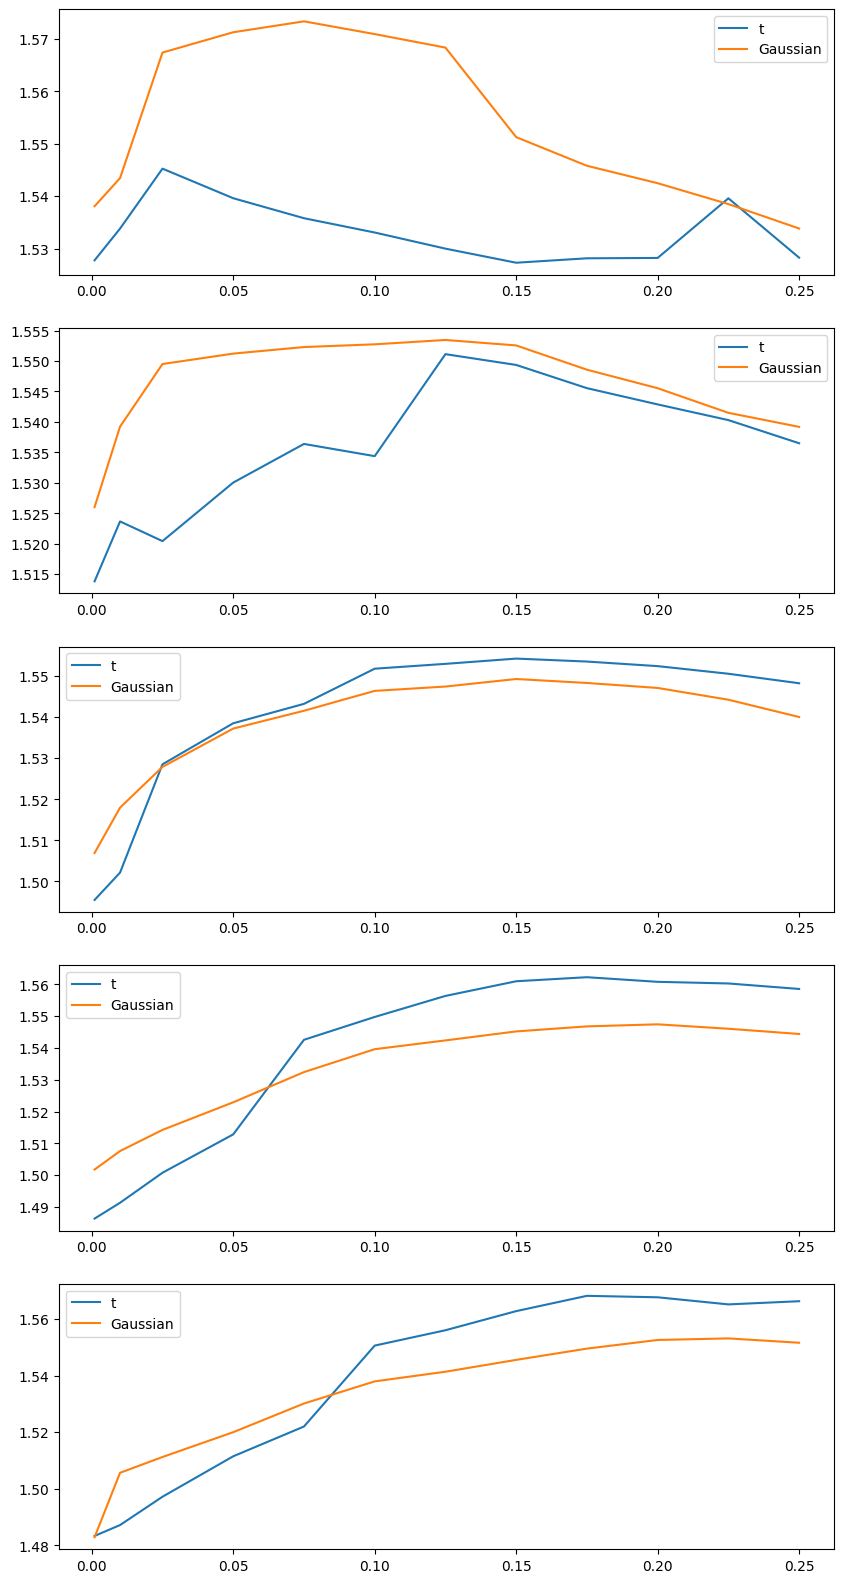

In [36]:
t_port = []
n_port = []
kappas = [0.1,0.2, 0.3, 0.4, 0.5]
for kappa in kappas:

    with open(f'../data/case_study_etf/t_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        t_port1 = pickle.load(handle)
    mean_mdd_t = []
    for cnt, alpha in enumerate(t_port1['alphas']):
        mean_mdd_t.append(np.mean(t_port1['omegas_s'][cnt]))
    
    t_port.append(mean_mdd_t)

    with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_k_{kappa}_disjoint_20.pkl', 'rb') as handle:
        n_port1 = pickle.load(handle)
    mean_mdd_n = []
    for cnt, alpha in enumerate(n_port1['alphas']):
        mean_mdd_n.append(np.mean(n_port1['omegas_s'][cnt]))
    
    n_port.append(mean_mdd_n)


fig, ax = plt.subplots(len(kappas),1,figsize = (10,20))
for cnt, kappa in enumerate(kappas):
    ax[cnt].plot(t_port1['alphas'][:len(t_port[cnt])], t_port[cnt], label = f't')
    ax[cnt].plot(n_port1['alphas'][:len(n_port[cnt])], n_port[cnt], label = f'Gaussian')

    ax[cnt].legend()

## Plot likelihhods

In [24]:
static_gaussian_port.keys()

dict_keys(['alphas', 'time_index', 'time_change', 'time_forecast', 'ticker_list', 'groups', 'price', 'X', 'l', 'obs_per_graph', 'gammas', 'Ss', 'Cs', 'tol', 'max_iter', 'ebics', 'thetas', 'nus', 'fro_norms', 'mus', 'sharpes_s', 'mdds_s', 'ws_s', 'mus_s', 'vars_s', 'rs_s', 'omegas_s', 'port_price_s', 'sigmas_s', 'sharpes_m', 'mdds_m', 'ws_m', 'mus_m', 'vars_m', 'rs_m', 'omegas_m', 'port_price_m', 'sigmas_m'])

In [23]:

with open(f'../data/case_study_etf/gaussian_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_gaussian_port = pickle.load(handle)
with open(f'../data/case_study_etf/t_nr_quad_10_etf_static_no_w_constr.pkl', 'rb') as handle:
    static_t_port = pickle.load(handle)

    mean_mdd_t = []
    mean_mdd_n = []
    for cnt, alpha in enumerate(static_gaussian_port['alphas']):
        mean_mdd_n.append(np.mean(static_gaussian_port['likelihoods'][cnt]))
        mean_mdd_t.append(np.mean(static_t_port['likelihoods'][cnt]))
        


fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(static_gaussian_port['alphas'], mean_mdd_t, label = 'static t')
ax.plot(static_gaussian_port['alphas'], mean_mdd_n, label = 'static gaussian')
ax.legend()



KeyError: 'likelihoods'

In [178]:
import requests
response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies" )
ticker_data = pd.read_html(response.content)[0]
ticker_data['group'] = 0
ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Financials', 'Health Care', 'Information Technology','Real Estate' ))] = 2


rndstate = np.random.RandomState(6)
index = rndstate.choice(np.array(range(500)),size = 30,replace=False)
ticker_list = np.array(ticker_data['Symbol'].iloc[index]).tolist()
groups_according_to_ticker = np.array(ticker_data['group'].iloc[index])

start_date= "2016-01-01"
end_date="2023-02-01"

import yfinance as yf
data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]

# reorder groups according to log_returns scaled as they are in alphabetical order
groups = np.array([j for i,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

C:\Users\User\AppData\Local\Temp\ipykernel_10084\2793740168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Energy', 'Materials', 'Industrials','Utilities' ))] = 0
C:\Users\User\AppData\Local\Temp\ipykernel_10084\2793740168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['group'].loc[np.isin(ticker_data['GICS Sector'], ('Communication Services', 'Consumer Discretionary', 'Consumer Staples' ))] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_10084\2793740168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

[*********************100%***********************]  30 of 30 completed


In [180]:
log_returns_scaled.columns

Index(['A', 'AES', 'APD', 'BA', 'BEN', 'BRO', 'CMS', 'CVS', 'EQIX', 'EQR',
       'FDX', 'FIS', 'GRMN', 'GS', 'INTC', 'IT', 'IVZ', 'MCHP', 'META', 'MPC',
       'MSFT', 'MTCH', 'NOC', 'PCAR', 'RHI', 'SIVB', 'SYF', 'SYK', 'TXT',
       'ZBRA'],
      dtype='object')

In [181]:
sorted(zip(ticker_list, groups_according_to_ticker))

[('A', 2),
 ('AES', 0),
 ('APD', 0),
 ('BA', 0),
 ('BEN', 2),
 ('BRO', 2),
 ('CMS', 0),
 ('CVS', 2),
 ('EQIX', 2),
 ('EQR', 2),
 ('FDX', 0),
 ('FIS', 2),
 ('GRMN', 1),
 ('GS', 2),
 ('INTC', 2),
 ('IT', 2),
 ('IVZ', 2),
 ('MCHP', 2),
 ('META', 1),
 ('MPC', 0),
 ('MSFT', 2),
 ('MTCH', 1),
 ('NOC', 0),
 ('PCAR', 0),
 ('RHI', 0),
 ('SIVB', 2),
 ('SYF', 2),
 ('SYK', 2),
 ('TXT', 0),
 ('ZBRA', 2)]

In [179]:
[j for i,j in sorted(zip(ticker_list, groups_according_to_ticker))]  

[2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 2]

In [160]:
start_date= "2016-01-01"
end_date="2023-02-01"

import yfinance as yf
data = yf.download(ticker_list, start_date , end_date)

log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]

[*********************100%***********************]  30 of 30 completed


In [163]:
ticker_list

['PKG',
 'BWA',
 'PNW',
 'DPZ',
 'CVX',
 'RJF',
 'POOL',
 'ED',
 'BIIB',
 'TSCO',
 'AAP',
 'FRT',
 'ROST',
 'CPT',
 'PCG',
 'PHM',
 'WYNN',
 'AEP',
 'MU',
 'SPGI',
 'WY',
 'WHR',
 'LHX',
 'OKE',
 'BMY',
 'UNP',
 'XYL',
 'GRMN',
 'CRL',
 'NWL']

In [162]:
log_returns_scaled.columns

Index(['AAP', 'AEP', 'BIIB', 'BMY', 'BWA', 'CPT', 'CRL', 'CVX', 'DPZ', 'ED',
       'FRT', 'GRMN', 'LHX', 'MU', 'NWL', 'OKE', 'PCG', 'PHM', 'PKG', 'PNW',
       'POOL', 'RJF', 'ROST', 'SPGI', 'TSCO', 'UNP', 'WHR', 'WY', 'WYNN',
       'XYL'],
      dtype='object')

In [165]:
log_returns_scaled.columns

Index(['AAP', 'AEP', 'BIIB', 'BMY', 'BWA', 'CPT', 'CRL', 'CVX', 'DPZ', 'ED',
       'FRT', 'GRMN', 'LHX', 'MU', 'NWL', 'OKE', 'PCG', 'PHM', 'PKG', 'PNW',
       'POOL', 'RJF', 'ROST', 'SPGI', 'TSCO', 'UNP', 'WHR', 'WY', 'WYNN',
       'XYL'],
      dtype='object')

In [167]:
sorted(zip(ticker_list, groups))

[('AAP', 1),
 ('AEP', 0),
 ('BIIB', 2),
 ('BMY', 2),
 ('BWA', 1),
 ('CPT', 2),
 ('CRL', 2),
 ('CVX', 0),
 ('DPZ', 1),
 ('ED', 0),
 ('FRT', 2),
 ('GRMN', 1),
 ('LHX', 0),
 ('MU', 2),
 ('NWL', 1),
 ('OKE', 0),
 ('PCG', 0),
 ('PHM', 1),
 ('PKG', 0),
 ('PNW', 0),
 ('POOL', 1),
 ('RJF', 2),
 ('ROST', 1),
 ('SPGI', 2),
 ('TSCO', 1),
 ('UNP', 0),
 ('WHR', 1),
 ('WY', 2),
 ('WYNN', 1),
 ('XYL', 0)]

In [164]:
np.where(log_returns_scaled.columns == ticker_list)

(array([25], dtype=int64),)

### MMD between matrices

In [104]:
t_port['Ss'][0]

[array([[ 0.40694009,  0.11268457,  0.07256155,  0.07668409,  0.10282186,
          0.11503969,  0.13685837,  0.17818374,  0.07152661,  0.12653499,
          0.15538891],
        [ 0.11268457,  0.46395931,  0.24139761,  0.29887974,  0.2767459 ,
          0.22969721,  0.09683661,  0.01449951,  0.13444185,  0.21875873,
          0.28061071],
        [ 0.07256155,  0.24139761,  0.66990648,  0.21940584,  0.16885511,
          0.09204396,  0.03918344, -0.00427547,  0.0546681 ,  0.11072932,
          0.17285539],
        [ 0.07668409,  0.29887974,  0.21940584,  0.62441271,  0.30743875,
          0.24666341,  0.07885716, -0.07674053,  0.1670924 ,  0.25059681,
          0.31052125],
        [ 0.10282186,  0.2767459 ,  0.16885511,  0.30743875,  0.3510012 ,
          0.23291782,  0.10182053,  0.02057851,  0.14620386,  0.220679  ,
          0.2546925 ],
        [ 0.11503969,  0.22969721,  0.09204396,  0.24666341,  0.23291782,
          0.4290805 ,  0.13143337,  0.0354417 ,  0.19789067,  0.2646867

In [16]:
gaussian_port['Ss'][0][25]

array([[0.58858782, 0.24688863, 0.18511434, 0.23768209, 0.275686  ,
        0.34048645, 0.32991663, 0.31592916, 0.30484103, 0.30419523,
        0.3034444 ],
       [0.24688863, 0.93248292, 0.71641268, 0.69651224, 0.77461315,
        0.73093537, 0.36336424, 0.07279198, 0.45349959, 0.60361756,
        0.69193236],
       [0.18511434, 0.71641268, 1.53845454, 0.83552787, 0.81694025,
        0.80647774, 0.3166719 , 0.01767632, 0.49555379, 0.66588279,
        0.84322443],
       [0.23768209, 0.69651224, 0.83552787, 1.0920955 , 0.8081374 ,
        0.83106202, 0.38155678, 0.05753096, 0.52783424, 0.6892334 ,
        0.80713234],
       [0.275686  , 0.77461315, 0.81694025, 0.8081374 , 0.98310879,
        0.8310421 , 0.38741279, 0.0768172 , 0.50493322, 0.68991031,
        0.7949517 ],
       [0.34048645, 0.73093537, 0.80647774, 0.83106202, 0.8310421 ,
        1.31901089, 0.41997633, 0.11337453, 0.65518485, 0.88377904,
        0.94986228],
       [0.32991663, 0.36336424, 0.3166719 , 0.38155678, 0.

In [30]:
import GTST
MMD_out = GTST.MMD()
MMD_out.fit(G1 = [nx.from_numpy_array(t_port['Ss'][0][i]) for i in range(20)], G2 = [nx.from_numpy_array(gaussian_port['Ss'][0][i]) for i in range(20)], 
            kernel = 'RW_ARKU_plus', mmd_estimators = 'MMD_u', r = 6, c = 0.00008, edge_attr = 'weight',Q=5)  
print(f" RW_ARKU_plus {MMD_out.p_values}")

Using weight as edge attributes
 RW_ARKU_plus {'MMD_u': 0.383}


<AxesSubplot:>

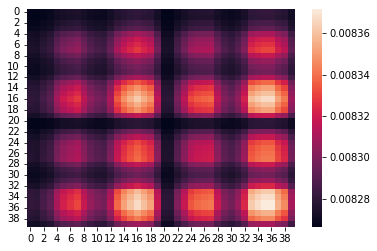

In [31]:
import seaborn as sns
sns.heatmap(MMD_out.K)

In [51]:
len(gt_port['Ss'][0])

21

In [57]:
gt_port['thetas'][0][-1]

array([[[ 4.08608605, -0.13050656,  0.16215641, ..., -0.0452828 ,
         -0.89832004, -0.13209369],
        [-0.13050656,  4.4375643 , -0.61803935, ...,  0.20490182,
         -0.2447168 , -0.15044082],
        [ 0.16215641, -0.61803935,  1.59469283, ..., -0.22213131,
         -0.27891629, -0.08004994],
        ...,
        [-0.0452828 ,  0.20490182, -0.22213131, ...,  4.68138873,
         -0.29033703,  0.04825175],
        [-0.89832004, -0.2447168 , -0.27891629, ..., -0.29033703,
          6.53040941, -0.83346136],
        [-0.13209369, -0.15044082, -0.08004994, ...,  0.04825175,
         -0.83346136,  2.41302645]],

       [[ 4.08561824, -0.1315588 ,  0.16037965, ..., -0.04555137,
         -0.89875567, -0.13300222],
        [-0.1315588 ,  4.43724261, -0.62052697, ...,  0.20382897,
         -0.24817573, -0.15265228],
        [ 0.16037965, -0.62052697,  1.59205182, ..., -0.22349923,
         -0.28106878, -0.0819152 ],
        ...,
        [-0.04555137,  0.20382897, -0.22349923, ...,  

In [71]:
import GTST
MMD_out = GTST.MMD()
MMD_out.fit(G1 = [nx.from_numpy_array(t_port['thetas'][0][i][-1]) for i in range(10,20)], G2 = [nx.from_numpy_array(gaussian_port['thetas'][0][i][-1]) for i in range(10,20)], 
            kernel = 'RW_ARKU_plus', mmd_estimators = 'MMD_u', r = 5, c = 0.005, edge_attr = 'weight',Q=5)  
print(f" RW_ARKU_plus {MMD_out.p_values}")

Using weight as edge attributes
 RW_ARKU_plus {'MMD_u': 0.006}


In [75]:
gt_port['Ss'][0][0]

array([[ 0.42465705,  0.10508556,  0.07127481,  0.07225937,  0.0933854 ,
         0.11107053,  0.13074265,  0.17869316,  0.06384055,  0.11636746,
         0.14856416],
       [ 0.10508556,  0.44345818,  0.23723943,  0.28703186,  0.25657384,
         0.21427276,  0.08065005,  0.00468791,  0.123169  ,  0.19549531,
         0.26372837],
       [ 0.07127481,  0.23723943,  0.6615836 ,  0.21255977,  0.16038563,
         0.08775042,  0.02751214, -0.00831321,  0.04989833,  0.09666234,
         0.164366  ],
       [ 0.07225937,  0.28703186,  0.21255977,  0.64123282,  0.29305948,
         0.24208324,  0.0660708 , -0.08765702,  0.17302809,  0.23510618,
         0.29881118],
       [ 0.0933854 ,  0.25657384,  0.16038563,  0.29305948,  0.32141092,
         0.21535788,  0.08586058,  0.01022409,  0.13509998,  0.19606624,
         0.2331417 ],
       [ 0.11107053,  0.21427276,  0.08775042,  0.24208324,  0.21535788,
         0.43134888,  0.12075685,  0.0270984 ,  0.19441904,  0.24728226,
         0.303

In [125]:
def off_zero(X):
    X_TMP = X.copy()

    np.fill_diagonal(X_TMP, 0)
    return X_TMP

import GTST
MMD_out = GTST.MMD()
MMD_out.fit(G1 = [nx.from_numpy_array(off_zero(t_port['Ss'][0][i])) for i in range(30)], G2 = [nx.from_numpy_array(off_zero(gaussian_port['Ss'][0][i])) for i in range(30)], 
            kernel = 'RW_ARKU_plus', mmd_estimators = 'MMD_u', r = 5, c = 0.00005, edge_attr = 'weight',Q=5)  
print(f" RW_ARKU_plus {MMD_out.p_values}")

Using weight as edge attributes
 RW_ARKU_plus {'MMD_u': 0.358}


In [91]:
MMD_out.sample_mmd

{'MMD_u': 1.5366328264106166e-05}